In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

<font size="4">Differentiable Physics-Assisted Neural Network (DPNN) as coarse grained surrogate for spatio-temporal predictions </font>

We will use this Jupyter Notebook to run the pre-trained model based on study [ArXiv link here]. The work is aimed at enabling a coarse-grained surrogate for unsteady fluid flows for low reynolds number flow past arbitrarily shaped bodies placed in an equilateral triangle position as shown below. 

<table><tr>
<td> <img src="images/shape_layout2.png" style="width: 700px;"/> </td>
<td> <img src="images/flowfield.png" style="width: 705px;"/> </td>
</tr></table>

The flowfield can be categorised as follows:

<ol>
  <li>Incompressible, low Reynolds $Re\sim$ 100.</li>
  <li>Dynamic viscosity, $\nu$ = 0.01 $Ns/m^2$</li>
  <li>Constant time-step, $\Delta t$ = 0.1s</li>    
  <li>Constant freestream velocity, $U$ = 1m/s</li>     
</ol>

The governing equation representing the fluid behaviour is described by the Navier-Stokes equatios as follows:
$$\begin{aligned}
    \frac{\partial \mathbf{u}}{\partial{t}} + \mathbf{u} \cdot \nabla \mathbf{u} &= - \frac{1}{\rho} \nabla p + \nu \nabla\cdot \nabla \mathbf{u}
  \quad \text{s.t.} \quad \nabla \cdot \mathbf{u} = 0,
\end{aligned}$$


The computational domain and the geometries immersed in it are as defined as:

<ol>
  <li>Spacing ratio: 1.2$\leq L/D\leq$5.5</li>
  <li>Constraing on the dimensions on the downstream cylinder: $H_{\mathrm{C2}}$+$D_{\mathrm{C3}}$=2$H_{\mathrm{C1}}$</li>  
  <li>Computational domina size: [0,24D] $\times$ [0,16D]</li>
  <li>Grid spacing: $\Delta x/D$ = $\Delta y/D$ = 1/32</li>    
</ol>

The above grid spacing corresponds to the flowfields obtained using [FoamExtend V4.0](https://www.tfd.chalmers.se/~hani/kurser/OS_CFD_2015/HrvojeJasak/ImmersedBoundary.pdf) as the $\textit{Reference}$ solver. 

$\textbf{Learning outcomes}$:

At the end of this notebook, you should be able to learn the following: 

  1. Execute the residual network-based ResNet architecture to model unsteady flow past a representative configuration using a pre-trained model
  2. Enable a $\textit{solver-in-the-loop}$ [Um et al 2020](https://arxiv.org/abs/2007.00016)  philosophy to best leverage differentiable solvers for efficient modelling of complex unsteady fluid dynamics
  3. Evaluate the pre-processing and post-processing tools to evaluate multiple parameters of interest such as Enstrophy $\Omega$, power spectrum $PS$, Strouhal number $St$, etc.

Lets start by loading the necessary library files and installing requisite softwares such as Phiflow $\Phi_{\mathrm{flow}}$. 

In [12]:
#!pip install phiflow==2.1.3
import tensorflow as tf
from phi.tf.flow import *
from tensorflow import keras
import random
from phi import __version__
import time
import numpy as np

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import pylab
import matplotlib.colors as colors

from scipy.linalg import svd
from scipy import signal
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.signal import find_peaks

from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from numpy import diff

print("Tensorflow version: {}".format(tf.__version__))
print("Numpy version: {}".format(numpy.__version__))
print("Scipy version: {}".format(scipy.__version__))
print("Phiflow version: {}".format(phi.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.3.0
Numpy version: 1.20.3
Scipy version: 1.9.3
Phiflow version: 2.1.3
Num GPUs Available:  0


As mentioned earlier, we will make use of arbitrary bodies which are a composite body (shown below) made of either a rectangle of random length and heigth or a circle or random diamater. These can be created using the $\texttt{phi.geom}$ module in [Phiflow](https://tum-pbs.github.io/PhiFlow/phi/geom/). 

As noted below, the composite body consists of a base rectangle (shared region) which is surrounded by 4 bodies on its sides, $i.e.,$ either a rectangle or a semi-circle. The coordinates of the vertex of the rectangles and the radius of the semi-circle are contained in a list. The following function is used to read the list and convert it into a [Obstacle](https://tum-pbs.github.io/PhiFlow/phi/physics/fluid.html) using $\Phi_{\mathrm{flow}}$. 

<img src="images/geom.png" style="width: 200px;"/>

In [5]:
# convert coordinates to phiflow objects

def convert_to_obj(geo_coor):
    
    #ar = geo_coor.values.numpy(('batch', 'x', 'y'))
    ar = geo_coor
    
    br_x1 = ar[0][0,1]
    br_x2 = ar[0][0,3]

    br_y1 = ar[0][0,4]
    br_y2 = ar[0][0,6]

    #print('base_rect', br_x1, br_x2, br_y1, br_y2)

    obj1 = (Box[br_x1:br_x2,br_y1:br_y2]) # base rectangle

    if (ar[0][1,0])==1: # 1 signifies a rectangle

        r_x1 = ar[0][1,1]
        r_x2 = ar[0][1,7]

        r_y1 = ar[0][1,4]
        r_y2 = ar[0][1,2]

        #print('rect 1', r_x1, r_x2, r_y1, r_y2)

        obj2 = (Box[r_x1:r_x2,r_y1:r_y2])

    elif (ar[0][1,0])==0: # 0 signifies a circle

        c_x1 = ar[0][1,1]
        c_y1 = ar[0][1,2]
        c_rad1 = ar[0][1,3]

        #print('circ 1', c_x1, c_y1, c_rad1)

        c_center = tensor((c_x1, c_y1), channel('vector'))

        obj2 = Sphere(center=c_center, radius=c_rad1)


    if (ar[0][2,0])==1: # 1 signifies a rectangle

        r_x1 = ar[0][2,1]
        r_x2 = ar[0][2,3]

        r_y1 = ar[0][2,4]
        r_y2 = ar[0][2,6]

        #print('rect 2', r_x1, r_x2, r_y1, r_y2)

        obj3 = (Box[r_x1:r_x2,r_y1:r_y2])

    elif (ar[0][2,0])==0: # 0 signifies a circle

        c_x1 = ar[0][2,1]
        c_y1 = ar[0][2,2]
        c_rad1 = ar[0][2,3]

        #print('circ 2', c_x1, c_y1, c_rad1)

        c_center = tensor((c_x1, c_y1), channel('vector'))

        obj3 = Sphere(center=c_center, radius=c_rad1)                


    if (ar[0][3,0])==1: # 1 signifies a rectangle

        r_x1 = ar[0][3,7]
        r_x2 = ar[0][3,1]

        r_y1 = ar[0][3,2]
        r_y2 = ar[0][3,4]

        #print('rect 3', r_x1, r_x2, r_y1, r_y2)

        obj4 = (Box[r_x1:r_x2,r_y1:r_y2])

    elif (ar[0][3,0])==0: # 0 signifies a circle

        c_x1 = ar[0][3,1]
        c_y1 = ar[0][3,2]
        c_rad1 = ar[0][3,3]

        #print('circ 3', c_x1, c_y1, c_rad1)

        c_center = tensor((c_x1, c_y1), channel('vector'))

        obj4 = Sphere(center=c_center, radius=c_rad1)          


    if (ar[0][4,0])==1: # 1 signifies a rectangle

        r_x1 = ar[0][4,3]
        r_x2 = ar[0][4,1]

        r_y1 = ar[0][4,6]
        r_y2 = ar[0][4,4]

        #print('rect 4', r_x1, r_x2, r_y1, r_y2)

        obj5 = (Box[r_x1:r_x2,r_y1:r_y2])

    elif (ar[0][4,0])==0: # 0 signifies a circle

        c_x1 = ar[0][4,1]
        c_y1 = ar[0][4,2]
        c_rad1 = ar[0][4,3]

        #print('circ 4', c_x1, c_y1, c_rad1)

        c_center = tensor((c_x1, c_y1), channel('vector'))

        obj5 = Sphere(center=c_center, radius=c_rad1)  


    if (ar[0][5,0])==1: # 1 signifies a rectangle

        r_x1 = ar[0][5,1]
        r_x2 = ar[0][5,3]

        r_y1 = ar[0][5,4]
        r_y2 = ar[0][5,6]

        #print('rect 5', r_x1, r_x2, r_y1, r_y2)

        obj6 = (Box[r_x1:r_x2,r_y1:r_y2])

    elif (ar[0][5,0])==0: # 0 signifies a circle

        c_x1 = ar[0][5,1]
        c_y1 = ar[0][5,2]
        c_rad1 = ar[0][5,3]

        #print('circ 5', c_x1, c_y1, c_rad1)

        c_center = tensor((c_x1, c_y1), channel('vector'))

        obj6 = Sphere(center=c_center, radius=c_rad1)  


    if (ar[0][6,0])==1: # 1 signifies a rectangle

        r_x1 = ar[0][6,1]
        r_x2 = ar[0][6,3]

        r_y1 = ar[0][6,4]
        r_y2 = ar[0][6,6]

        #print('rect 6', r_x1, r_x2, r_y1, r_y2)

        obj7 = (Box[r_x1:r_x2,r_y1:r_y2])

    elif (ar[0][6,0])==0: # 0 signifies a circle

        c_x1 = ar[0][6,1]
        c_y1 = ar[0][6,2]
        c_rad1 = ar[0][6,3]

        #print('circ 6', c_x1, c_y1, c_rad1)

        c_center = tensor((c_x1, c_y1), channel('vector'))

        obj7 = Sphere(center=c_center, radius=c_rad1) 


    multiple_obj = [obj1, obj2, obj3, obj4, obj5, obj6, obj7]

    obstacle = Obstacle(union(multiple_obj))
    
    return multiple_obj
    #return obj1, obj2, obj3, obj4, obj5, obj6, obj7


The high-resolution (HR) flowfields generated using the $\textit{Reference}$ solver is used as the ground truth data. The $n_x \times n_y$ = 768 $\times$ 512 HR based flowfield is downsampled (left) 3$\times$ times by repeating the custom $\texttt{phi.math.downsample2x}$ 3 times to create a downsampled verison of the same (right). This is fed to the network as an input, to mimic the idea of "coarse-grained" surrogate for faster computation. Note that on the resulting coarse mesh, the base solver ($\textit{i.e.,} Source$) will result in dissipative flowfield. The "hope" is then to create a hybrid NN-based predictive framework which is able to counter the dissipative nature of the $\textit{Source}$ solver. 

<table><tr>
<td> <img src="images/HR.png" style="width: 700px;"/> </td>
<td> <img src="images/LR.png" style="width: 700px;"/> </td>
</tr></table>

In [6]:
def downsample_field(data_u, data_v, data_ibm, downx):
    
    stacked = phi.math.stack([data_u,data_v], phi.math.channel('vector'))
    
    if downx==0:
        down_vel = phi.math.tensor(stacked)
        down_ibm = data_ibm
    
    if downx>0:
        for k in range(downx):

            down_vel = phi.math.downsample2x(stacked)
            down_ibm = phi.math.downsample2x(data_ibm)
            
            stacked = phi.math.stack([down_vel.vector[0],down_vel.vector[1]], phi.math.channel('vector'))
            data_ibm = down_ibm
    
    return down_vel.vector[0].numpy('x,y'), down_vel.vector[1].numpy('x,y'), down_ibm.numpy('x,y') 

Lets start now by extracting a representative flowfield from the $\textit{Reference}$ solver. Make a note of the following:

 1. The developing flowfield corresponding to the first few frames (in this case 1500) are discarded to only allow for stastically stable flowfields for training and inference
 2. The HR flowfields are downsmapled 3$\times$ times as explained above
 3. The flowfield is stored as .npz files which after loading are converted into a Dict.

In [7]:
total_frames = 100 # total number of training frames from th avialable 3000 frames
sub_frames = 100
Nx = 768
Ny = 512
L = 24
H = 16

remove_transient = 1500           # remove transient frames in the range 0-2900 (in multiple of 100, e.g., 0, 100, 200, ...2900)
end_frame = remove_transient + total_frames     # window of frames to be considered

range_i = np.int32(remove_transient/sub_frames)
range_e = np.int32(end_frame/sub_frames)
print(range_i, range_e)

downsample = 3 # 0 for no downsampling, 1 for downsampling by 2x, 2 for downsampling by 4x

configs = 1

def load_npz(file_name1,file_name2,range_i,range_e,Nx,Ny):

    alist_foam = []
    z=0
    for i in range(range_i,range_e,1):

        fname = file_name1 + 'comp_frames_range_' + str(i) + '.npz'
        data_of = np.load(fname)['arr_0']

        data_geo = np.loadtxt(file_name2, delimiter = ",", skiprows=0)

        for j in range(sub_frames):

            u_vel = np.transpose(np.reshape(data_of[j][:,0]*1.0, (Ny,Nx)))
            v_vel = np.transpose(np.reshape(data_of[j][:,1]*1.0, (Ny,Nx)))
            ibmask = np.transpose(np.reshape(data_of[j][:,3]*1.0, (Ny,Nx)))

            data_u = phi.math.tensor(u_vel,spatial('x','y'))
            data_v = phi.math.tensor(v_vel,spatial('x','y'))
            data_ibm = phi.math.tensor(ibmask,spatial('x','y'))

            down_u, down_v, down_ibm = downsample_field(data_u, data_v, data_ibm, downsample)

            re_u = down_u.reshape(1,down_u.shape[0], down_u.shape[1])
            re_v = down_v.reshape(1,down_v.shape[0], down_v.shape[1])
            re_ibm = down_ibm.reshape(1,down_ibm.shape[0], down_ibm.shape[1])
            re_coor = data_geo.reshape(1,data_geo.shape[0], data_geo.shape[1])
            #print(re_u.shape, re_ibm.shape)

            obj = convert_to_obj(re_coor)

            alist_foam.append([re_ibm,re_u,re_v,obj])
            arr = np.array(alist_foam,dtype=object)

    del data_of
    del alist_foam
    del data_geo

    return arr


start = time.time()

data_preloaded = {}

arr_foam = []
sim_name = []


for j in range (configs):

    suffix = '../../../../data/Shuvayan_new_data/3_HR_mod_data/'

    path1 = suffix + 'foamExtend_folders/geo/geo_' + str(j) + '/flowfield_data/'
    path2 = suffix + '2_shape_coors/geo_' + str(j) + '.dat'

    arr_foam.append(load_npz(path1,path2,range_i,range_e,Nx,Ny))

    sim_name1 = 'openfoam_database/sim_' + str(j)
    sim_name.append(sim_name1)

for j in range (configs):

    data_preloaded[sim_name[j]] = arr_foam[j]
    #print(len(data_preloaded[sim_name[j]]))

end = time.time()

print('Time taken to load {} configs and {} training frames: {}'.format(configs, total_frames, end-start))

15 16
Time taken to load 1 configs and 100 training frames: 7.757887125015259


The following cell will display the $u$ and $v$ velocity flowfield frames at a certain time frame along with the shape mask $m_f \in$ $R^{n_x \times n_y}$.

<IPython.core.display.Javascript object>


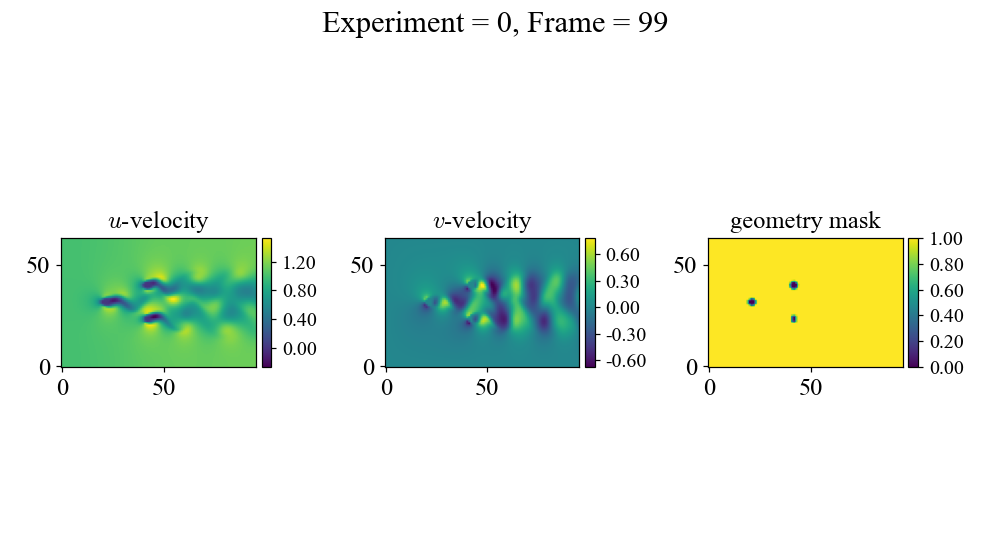

Openfoam data into dictionary: data_preloaded

Shape of the resulting n-dimensional matrix (100, 4)
1 Experiment
100 Frames
3 Variables: u-vel, v-vel, geo_mask
Grid size (96, 64)
Final dataEntry: Coordinates of the shapes (not an input ot the network)


In [9]:
%matplotlib notebook

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 16
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['hatch.linewidth'] = 0.35

ticks_font = fm.FontProperties(family='Times New Roman', style='normal', size=13, weight='normal', stretch='normal')

sim_key = 0        # also refers to the shape
frame_num = 99         # indicates the flowfield at a particular time instance

ib_mask = math.tensor(data_preloaded[sim_name[sim_key]][frame_num][0][0][:][:],spatial('x','y'))
u_vel = math.tensor(data_preloaded[sim_name[sim_key]][frame_num][1][0][:][:],spatial('x','y'))
v_vel = math.tensor(data_preloaded[sim_name[sim_key]][frame_num][2][0][:][:],spatial('x','y'))
mobj = data_preloaded[sim_name[sim_key]][frame_num][3]

m,n = data_preloaded[sim_name[sim_key]][frame_num][0][0][:][:].shape

stacked = math.stack([u_vel,v_vel], math.channel('vector'))
                     
grid_datas = StaggeredGrid(stacked)
grid_ibm = CenteredGrid(ib_mask)

nx = 96
ny = 64
L = 24
H = 16

DOMAIN = dict(x=nx, y=ny,bounds=Box[0:L,0:H], extrapolation=extrapolation.combine_sides(x=extrapolation.BOUNDARY, y=extrapolation.ZERO))

gridc = CenteredGrid(stacked, **DOMAIN)

velocity = phi.math.vec_length(gridc.values)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,5))

fig.suptitle('Experiment = ' + str(sim_key) + ', Frame = ' + str(frame_num) , fontsize=20) 
                               
ax1.set_title(r'$u$-velocity',fontsize=20,font='Times New Roman')
im1 = ax1.imshow(grid_datas.vector[0].values.numpy('y, x'), origin = 'lower', cmap='viridis')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1, ticks=MultipleLocator(0.2), format="%.2f")    
tick_locator = ticker.MaxNLocator(nbins=5)
cbar1.locator = tick_locator
cbar1.update_ticks()


ax2.set_title(r'$v$-velocity',fontsize=16,font='Times New Roman')
im2 = ax2.imshow(grid_datas.vector[1].values.numpy('y, x'), origin = 'lower', cmap='viridis')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2, ticks=MultipleLocator(0.2), format="%.2f")
tick_locator = ticker.MaxNLocator(nbins=5)
cbar2.locator = tick_locator
cbar2.update_ticks()

ax3.set_title('geometry mask',fontsize=16,font='Times New Roman')
im3 = ax3.imshow(grid_ibm.values.numpy('y, x'), origin = 'lower', cmap='viridis')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3, ticks=MultipleLocator(1), format="%.2f")
tick_locator = ticker.MaxNLocator(nbins=5)
cbar3.locator = tick_locator
cbar3.update_ticks()

ax = cbar3.ax

for lbl in ax.get_yticklabels():
    lbl.set_font_properties(ticks_font)

ax = cbar2.ax
for lbl in ax.get_yticklabels():
    lbl.set_font_properties(ticks_font)
    
ax = cbar1.ax
for lbl in ax.get_yticklabels():
    lbl.set_font_properties(ticks_font)

plt.tight_layout()

print('Openfoam data into dictionary: data_preloaded\n')
print('Shape of the resulting n-dimensional matrix {}'.format(data_preloaded[sim_name[sim_key]].shape))
print('{} Experiment'.format(len(data_preloaded)))

print('{} Frames'.format(len(data_preloaded[sim_name[sim_key]])))
print('{} Variables: u-vel, v-vel, geo_mask'.format(len(data_preloaded[sim_name[sim_key]][frame_num])-1))
print('Grid size {}'.format(data_preloaded[sim_name[sim_key]][frame_num][0][0][:][:].shape))
print('Final dataEntry: Coordinates of the shapes (not an input ot the network)')

if downsample==0:
    print('Ground truth not downsized')
    
elif downsample==1:
    print('Ground truth downsized 2x')
    
elif downsample==2:
    print('Ground truth downsized 4x')
    


The following cell describes the forward simulator build using custom $\Phi_{\mathrm{flow}}$ functions. Specifically, the forward simulator $\textit{i.e., Source}$ solves the NS equations using Operator-Splitting scheme. Specifically, MacCormack scheme is used for advection and secondly, Choris's method is used to obtain the divergence-free velocity fields. The following image shows the stark contrast betwen the local reconstruction approach employed by the two flowsolvers, $i.e., Reference$ ($\texttt{FoamExtend)}$) on the left and $\textit{Source}$ ($\texttt{PhiFlow}$), on the right. It is obvious that the former uses local algebraic reconstruction for the near body-boundary flow properties for accuracy whereas the latter resorts to masked stair-step representation of the body-boundary for computational efficiency.


<table><tr>
<td> <img src="images/foamExtend.png" style="width: 700px;"/> </td>
<td> <img src="images/Phiflow.png" style="width: 500px;"/> </td>
</tr></table>

In [10]:
DT = 0.1

Nx = 768
Ny = 512

if downsample==1:
    Nx = int(Nx/2)
    Ny = int(Ny/2)
if downsample==2:
    Nx = int(Nx/4)
    Ny = int(Ny/4)
if downsample==3:
    Nx = int(Nx/8)
    Ny = int(Ny/8)
if downsample==4:
    Nx = int(Nx/16)
    Ny = int(Ny/16)

offset = (L/Nx)*0.5

NU = 0.01
V = 1

class cyl_in_channel():
    def __init__(self, domain):
        self.domain = domain

        self.vel_BcMask = self.domain.staggered_grid(HardGeometryMask(Box[:offset, :]) )

    def step(self, mask_in, velocity_in, u_obj, seq, dt=DT):

        o_list = []

        for i in range(len(seq)):
            if seq[i]==1:
                o_list.append(Box[u_obj[i][0]:u_obj[i][1],u_obj[i][2]:u_obj[i][3]])

            if seq[i]==0:
                c_center = tensor((u_obj[i][0], u_obj[i][1]), channel('vector'))
                o_list.append(Sphere(center=c_center, radius=u_obj[i][2]))


        self.obstacle = [Obstacle(union(o_list))]

        velocity = velocity_in
        pressure = None

        velocity = phi.flow.diffuse.explicit(velocity, NU, dt=dt)
        velocity = advect.mac_cormack(velocity, velocity, dt=dt)
        velocity = velocity*(1.0 - self.vel_BcMask) + self.vel_BcMask * (1,0)
        velocity, pressure = fluid.make_incompressible(velocity, self.obstacle, Solve('CG', 1e-5, 1e-5, 2500, x0=None))

        return [mask_in, velocity]


The following cell builds the residual network (or ResNet) architecture as shown in the schematic below. Each ResNet block comprises two convolutional layers having 32 filters, each with a kernel of size of [5 $\times$5]. The network receives the following input:

 1. $u$-velocity flowfield at time $t$ = $t^{n}$
 2. $v$-velocity flowfield at time $t$ = $t^{n}$
 3. shape mask $m_f$

The networkproduces the following output;
 1. $u$-velocity flowfield at next time-step $t$ = $t^{n+1}$
 2. $v$-velocity flowfield at next time-step $t$ = $t^{n+1}$ 

Consequently, the network receives input of 3 channels and produces output of 2 channels. Throughtout the network architecture, no compression is performed via $\texttt{Stride}$ or $\texttt{maxPooling}$, which in our experience, seems to deterioriate the accuracy. $\texttt{ReLU}$ is employed as non-linear activation function. 

<img src="images/ResNet.png" style="width: 1200px;"/>

In [11]:
def network_ResNet(inputs_dict):
    l_input = keras.layers.Input(**inputs_dict)
    block_0 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_input)
    block_0 = keras.layers.ReLU()(block_0)

    l_conv1 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_0)
    l_conv1 = keras.layers.ReLU()(l_conv1)
    l_conv2 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv1)
    l_skip1 = keras.layers.add([block_0, l_conv2])
    block_1 = keras.layers.ReLU()(l_skip1)

    l_conv3 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_1)
    l_conv3 = keras.layers.ReLU()(l_conv3)
    l_conv4 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv3)
    l_skip2 = keras.layers.add([block_1, l_conv4])
    block_2 = keras.layers.ReLU()(l_skip2)
    
    l_conv5 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_2)
    l_conv5 = keras.layers.ReLU()(l_conv5)
    l_conv6 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv5)
    l_skip3 = keras.layers.add([block_2, l_conv6])
    block_3 = keras.layers.ReLU()(l_skip3)

    l_conv7 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_3)
    l_conv7 = keras.layers.ReLU()(l_conv7)
    l_conv8 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv7)
    l_skip4 = keras.layers.add([block_3, l_conv8])
    block_4 = keras.layers.ReLU()(l_skip4)

    l_conv9 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_4)
    l_conv9 = keras.layers.ReLU()(l_conv9)
    l_conv10 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv9)
    l_skip5 = keras.layers.add([block_4, l_conv10])
    block_5 = keras.layers.ReLU()(l_skip5)

    l_conv11 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_5)
    l_conv11 = keras.layers.ReLU()(l_conv11)
    l_conv12 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv11)
    l_skip6 = keras.layers.add([block_5, l_conv12])
    block_6 = keras.layers.ReLU()(l_skip6)

    l_conv13 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_6)
    l_conv13 = keras.layers.ReLU()(l_conv13)
    l_conv14 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv13)
    l_skip7 = keras.layers.add([block_6, l_conv14])
    block_7 = keras.layers.ReLU()(l_skip7)

    l_conv15 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_7)
    l_conv15 = keras.layers.ReLU()(l_conv15)
    l_conv16 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv15)
    l_skip8 = keras.layers.add([block_7, l_conv16])
    block_8 = keras.layers.ReLU()(l_skip8)

    l_conv17 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_8)
    l_conv17 = keras.layers.ReLU()(l_conv17)
    l_conv18 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv17)
    l_skip9 = keras.layers.add([block_8, l_conv18])
    block_9 = keras.layers.ReLU()(l_skip9)

    l_conv19 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_9)
    l_conv19 = keras.layers.ReLU()(l_conv19)
    l_conv20 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv19)
    l_skip10 = keras.layers.add([block_9, l_conv20])
    block_10 = keras.layers.ReLU()(l_skip10)

    l_output = keras.layers.Conv2D(filters=2,  kernel_size=5, padding='same')(block_10)
    return keras.models.Model(inputs=l_input, outputs=l_output, name='ResNet')    


The following functions acts as the interface between $\texttt{keras/Tensorflow}$ and $\texttt{Phiflow}$. The `to_keras` function converts the vector of inputs to resulting stack of grids via the $\texttt{math.channel}$ function, which is then fed to the network as an input. The `to_phiflow` function converts the 2-component tensor ($\textit{i.e.,}$ network out of two chennels) to an equivalent staggered grid via the $\texttt{domain.staggered}$_$\texttt{grid}$ function. This step is necessary as the innate network output cannot be processed by the base $\textit{Source}$ solver as it is and needs to be first converted into an equivalent grid. 



In [12]:
def to_keras(dens_vel_grid_array):

    x = math.stack(
        [
            dens_vel_grid_array[0].values,
            dens_vel_grid_array[1].vector['x'].x[:-1].values,
            dens_vel_grid_array[1].vector['y'].y[:-1].values,
        ],
        math.channel('channels')
    )
    return x

def to_phiflow(tf_tensor, domain):

    y = domain.staggered_grid(
        math.stack(
            [
                math.tensor(tf.pad(tf_tensor[..., 0], [(0,0), (0,1), (0,0)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
                math.tensor(tf.pad(tf_tensor[..., 1], [(0,0), (0,0), (0,1)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y'))
            ],math.channel('vector')
        )
    )
    return y


The following function creates a `dataset` class for storing all the downsampled ground-truth data obtained form the $\textit{Reference}$ solver. In addition, it also uses the constant scaling factors for standardising the datasets. The data format for the numpy array `dataPreloaded`: is  `['sim_name', frame, field (mask, u-vel, v-vel fields)]`, where each field has dimension `[batch-size, y-size, x-size, channels]`

In [13]:
class Dataset():
    def __init__(self, data_preloaded, num_frames, num_sims=None, batch_size=1, is_testset=False):
        self.epoch         = None
        self.epochIdx      = 0
        self.batch         = None
        self.batchIdx      = 0
        self.step          = None
        self.stepIdx       = 0

        self.dataPreloaded = data_preloaded
        self.batchSize     = batch_size

        self.numSims       = num_sims
        self.numBatches    = num_sims//batch_size
        self.numFrames     = num_frames
        self.numSteps      = num_frames

        if not is_testset:
            self.dataSims = ['openfoam_database/sim_%d'%i for i in range(num_sims) ]

        else:
            self.dataSims = ['openfoam_database/sim_%d'%i for i in range(num_sims) ]

        self.dataFrames = [ np.arange(num_frames) for _ in self.dataSims ]

        self.resolution = self.dataPreloaded[self.dataSims[0]][0][0].shape[1:4]

        self.dataStats = {
            'std': (
                0.06137310713529587, # mask
                0.25251612067222595, # x-velocity
                0.12689048051834106, # y-velocity
            )
        } # scaling factors for the pretrained model



    # re-shuffle data for next epoch
    def newEpoch(self, ep, exclude_tail=0, shuffle_data=True):
        self.numSteps = self.numFrames - exclude_tail
        simSteps = [ (asim, self.dataFrames[i][0:(len(self.dataFrames[i])-exclude_tail)]) for i,asim in enumerate(self.dataSims) ]

        sim_step_pair = []
        for i,_ in enumerate(simSteps):
            sim_step_pair += [ (i, astep) for astep in simSteps[i][1] ]  # (sim_idx, step) ...

        if shuffle_data:
            random.shuffle(sim_step_pair)
        self.epoch = [ list(sim_step_pair[i*self.numSteps:(i+1)*self.numSteps]) for i in range(self.batchSize*self.numBatches) ]
        self.epochIdx += 1
        self.batchIdx = 0
        self.stepIdx = 0


    def nextBatch(self):
        self.batchIdx += self.batchSize
        self.stepIdx = 0

    def nextStep(self):
        self.stepIdx += 1


The `nextEpoch`, `nextBatch`, and `nextStep` functions will be called at training time to randomize the order of the training data.

Now we need one more function that compiles the data for a mini batch to train with, called `getData` below. It returns batches of the desired size in terms of shape mask, $u$-velocity, $v$-velocity fields.

In [14]:
# for class Dataset():
def getData(self, consecutive_frames):

    mask_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][0] # variable
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    u_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][1] # variable
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]
    v_hi = [
        np.concatenate([
            self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1]+j # frames
            ][2] # variable
            for i in range(self.batchSize)
        ], axis=0) for j in range(consecutive_frames+1)
    ]

    coor_hi = [           self.dataPreloaded[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]] # sim_key
            ][
                self.epoch[self.batchIdx+i][self.stepIdx][1] # frames
            ][3] # variable
            for i in range(self.batchSize)
        ]

    return [mask_hi, u_hi, v_hi, coor_hi[0]]


In [15]:
nsims = configs # configs
batch_size = 1
simsteps = total_frames # frames

dataset = Dataset( data_preloaded=data_preloaded, num_frames=simsteps, num_sims=nsims, batch_size=batch_size)

In addition we define the resolution of the simulation in `source_res`, and allocate the fluid solver object called `simulator`. In order to create grids, it requires access to a `Domain` object, which mostly exists for convenience purposes: it stores resolution, physical size in `bounds`, and boundary conditions of the domain. This information needs to be passed to every grid, and hence it's convenient to have it in one place in the form of the `Domain`. For the setup described above, we need different boundary conditions along x and y: closed walls, and free flow in and out of the domain, respecitvely.

We also instantiate the actual NN `network` in the next cell.

In [16]:
from phi.physics._boundaries import Domain, OPEN, STICKY as CLOSED

source_res = list(dataset.resolution)

boundary_conditions = {
    'x':(phi.physics._boundaries.OPEN, phi.physics._boundaries.OPEN),
    'y':(phi.physics._boundaries.OPEN, phi.physics._boundaries.OPEN) }


domain = Domain(x=source_res[0], y=source_res[1], bounds=Box[0:L, 0:H], boundaries=boundary_conditions)

simulator = cyl_in_channel(domain=domain)

network = network_ResNet(dict(shape=(source_res[0],source_res[1], 3)))
network.summary()


Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 96, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 64, 32)   25632       re_lu[0][0]                      
_____________________________________________________________________________________________

/tmp/ipykernel_230320/1374047754.py:10: DeprecationWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation, **domain_dict)
  domain = Domain(x=source_res[0], y=source_res[1], bounds=Box[0:L, 0:H], boundaries=boundary_conditions)
/tmp/ipykernel_230320/1374047754.py:10: FutureWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation, **domain_dict)
  domain = Domain(x=source_res[0], y=source_res[1], bounds=Box[0:L, 0:H], boundaries=boundary_conditions)


The following funciton `obj_check` is intended to create the object representing the bodies depending on the case of it being a Sphere or a rectangle. 

In [17]:
def obj_check(geom):
    
    if str(geom)=='Sphere()':
        cx = geom.center[0]
        cy = geom.center[1]
        crad = geom.radius
        dummy = 0
        obj_gt = math.tensor([cx,cy,crad,dummy])
        seq = 0
    else:
        obj_gt = math.tensor([geom.lower[0],geom.upper[0],geom.lower[1],geom.upper[1]])
        seq = 1
    return obj_gt, seq

Finally, we are now in a position to load the weights of the pre-trained model and run some evaluations. The data generated during this process will be saved in the $\texttt{postProcessDir}$ named directory. 

In [18]:
LR = 1e-4
EPOCHS = 100

opt = tf.keras.optimizers.Adam(learning_rate=LR) 

resume = 50 # Weights corresponding to which Epoch
if resume>0: 
    ld_network = keras.models.load_model('ResNetWeights/./nn_epoch{:04d}.h5'.format(resume)) 
    network.set_weights(ld_network.get_weights())

    
save_dir = 'postProcessDir' 


print("Num GPUs Available: {}".format(len(tf.config.list_physical_devices('GPU'))))
print('Grid resolution: {}, downsample {}'.format(source_res, int(downsample)))
print('Remove Frames: {}'.format(remove_transient))
print('Test Frames: {} - {}'.format(remove_transient, remove_transient + total_frames))
print('Configs: {}'.format(configs))
print('Batch size: {}'.format(dataset.numBatches))
print('Learning rate: {}'.format(LR))
print('Epochs: {}'.format(EPOCHS))
print('output dir:  {}\n'. format(save_dir))
   


Num GPUs Available: 0
Grid resolution: [96, 64], downsample 3
Remove Frames: 1500
Test Frames: 1500 - 1600
Configs: 1
Batch size: 1
Learning rate: 0.0001
Epochs: 100
output dir:  postProcessDir



To start the evaluations, lets have a look at a typical convergence plot where we see the decay of the loss with training epochs for a total of 50 epochs. 

<IPython.core.display.Javascript object>


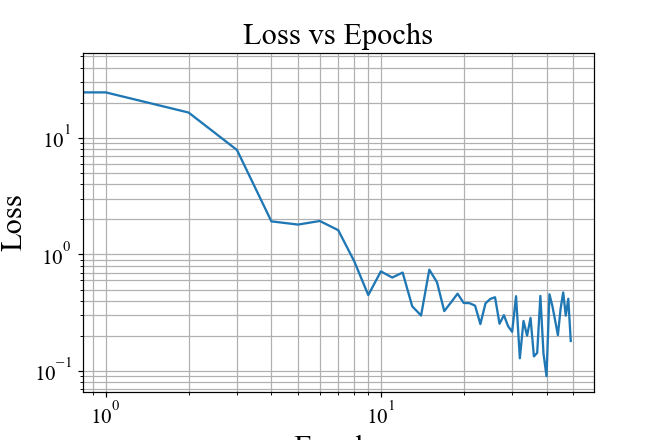

In [19]:
fname = 'ResNetWeights/epoch_vs_loss.dat'
data = np.loadtxt(fname, delimiter = ",", skiprows=0)

fig = plt.figure(figsize=(6,4))

ll = data[:50,1]
ee = data[:50,0]

plt.loglog(ee,ll)
plt.title('Loss vs Epochs', fontsize = 20)    
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.tick_params(labelsize=14)

plt.grid(True, which="both", ls="-")



In [20]:
def load_test_sim(idx, total_frames):
    
    Nx = 768
    Ny = 512
    downsample = 3
    

    arr_foam = []
    sim_name = []

    remove_transient = 1500 # frame number to where the ground truth should be considered
    end_frame = remove_transient + total_frames
    
    range_i = np.int32(remove_transient/sub_frames)
    range_e = np.int32(end_frame/sub_frames)

    z = 0

    testing_sim_key = idx

    for j in range (testing_sim_key,testing_sim_key+1,1):
                
        suffix = '../../../../data/Shuvayan_new_data/3_HR_mod_data/'
    
        path1 = suffix + 'foamExtend_folders/geo/geo_' + str(j) + '/flowfield_data/'
        path2 = suffix + '2_shape_coors/geo_' + str(j) + '.dat'

        arr_foam.append(load_npz(path1,path2,range_i,range_e,Nx,Ny))

        sim_name1 = 'openfoam_database/sim_' + str(z)
        z+=1
        sim_name.append(sim_name1)        

    for j in range (1):
        data_preloaded[sim_name[j]] = arr_foam[j]

    return data_preloaded

def plot_stuff(field,sub_title,num,cap):
    
    field_re = field
    var = math.tensor(field_re,spatial('x','y'))
    grid_var = CenteredGrid(var)
    
    im = axs[num].imshow(grid_var.values.numpy('y, x'), origin = 'lower', cmap='viridis')
    axs[num].title.set_text(sub_title)
    if cap==1:
        divider = make_axes_locatable(axs[num])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical');
        
    
def load_initial_frame(data_preloaded,tot_no_frames):
    
    dataset_test = Dataset( data_preloaded=data_preloaded, is_testset=True, num_frames=tot_no_frames, num_sims=1, batch_size=1)
    dataset_test.newEpoch(0, shuffle_data=False)
    batch = getData(dataset_test, consecutive_frames=0) 
    #print(dataset.dataStats['std'])
    initial_frame  = 0
    initial_geo = 0

    source_mask_initial = domain.scalar_grid(math.tensor(batch[0][initial_frame], math.batch('batch'), math.spatial('x, y')))

    source_vel_initial = domain.staggered_grid(phi.math.stack([
    math.tensor(tf.pad(batch[1][initial_frame][...,:,:],[(0,0), (0,1), (0,0)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
    math.tensor(tf.pad(batch[2][initial_frame][...,:,:],[(0,0), (0,0), (0,1)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
    ], math.channel('vector')))
    #source_coor_initial = domain.scalar_grid(math.tensor(batch[3][0], math.batch('batch'), math.spatial('x, y')))
    obj_l = []
    seq_l = []
    for l in tf.range(len(batch[3])):
        obj_gt, seq = obj_check(batch[3][l])
        obj_l.append(obj_gt)
        seq_l.append(seq)
    
    return source_mask_initial,source_vel_initial,obj_l,seq_l

def run_source(source_mask_initial, source_vel_initial, obj_l, seq_l,tot_no_frames):

    source_mask_test, source_vel_test, source_obj_test, source_seq_test = source_mask_initial, source_vel_initial, obj_l, seq_l
    steps_source = [[source_mask_test,source_vel_test]]

    for i in range(tot_no_frames):
        [source_mask_test,source_vel_test] = simulator.step(
            mask_in=source_mask_test,
            velocity_in=source_vel_test,
            u_obj = source_obj_test,
            seq = source_seq_test,
        )
        steps_source.append( [source_mask_test,source_vel_test] )

    #print("Source simulation steps "+format(len(steps_source)))
    return steps_source


def run_sim(source_mask_initial, source_vel_initial, obj_l, seq_l,tot_no_frames,network_c):
    
    source_mask_test, source_vel_test, source_obj_test, source_seq_test  = source_mask_initial, source_vel_initial, obj_l, seq_l
    steps_hybrid = [[source_mask_test,source_vel_test]]

    for i in range(tot_no_frames):
        [source_mask_test,source_vel_test] = simulator.step(
            mask_in=source_mask_test,
            velocity_in=source_vel_test,
        u_obj = source_obj_test,
        seq = source_seq_test,
        )
        model_input = to_keras([source_mask_test,source_vel_test])
        model_input /= math.tensor([dataset.dataStats['std'][0], dataset.dataStats['std'][1], dataset.dataStats['std'][2]], channel('channels')) # [mask, u, v]
        model_out = network_c(model_input.native(['batch', 'x', 'y', 'channels']), training=False)
        model_out *= [dataset.dataStats['std'][1], dataset.dataStats['std'][2]] # [u, v]

        correction = to_phiflow(model_out, domain)

        source_vel_test = source_vel_test+correction

        #vis.plot([(source_vel_test-correction)*1.0,correction*1.0,source_vel_test*1.0])

        steps_hybrid.append( [source_mask_test,source_vel_test] )

    #print("Solver steps :"+format(len(steps_hybrid)))  
        
    return steps_hybrid 

def calc_mae_frame(frame_id,data_preloaded,steps_hybrid):
    b = 0 # batch index for the following comparisons

    #index = frame_id
    err_pred = []
    
    for index in range(frame_id+1):
    
        cvel_ref = domain.staggered_grid(
            math.stack(
                [
                    math.tensor(tf.pad(data_preloaded[sim_name[0]][index][1][...,:,:],[(0,0), (0,1), (0,0)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
                    math.tensor(tf.pad(data_preloaded[sim_name[0]][index][2][...,:,:],[(0,0), (0,0), (0,1)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
                ], math.channel('vector')))

        svel_ref = cvel_ref

        vx_ref = svel_ref.vector[0].values.x[:].y[:].native(('batch', 'x', 'y'))
        vy_ref = svel_ref.vector[1].values.x[:].y[:].native(('batch', 'x', 'y'))

        vxh = vx_ref - (steps_hybrid[index][1]).values.vector[0].numpy('batch,x,y')[b,...]
        vyh = vy_ref - (steps_hybrid[index][1]).values.vector[1].numpy('batch,x,y')[b,...]

        mae_frame= np.mean(np.abs(vxh)) + np.mean(np.abs(vyh))
        err_pred.append(mae_frame)
 
    return mae_frame, err_pred, vxh[0], vyh[0]


def vel_probe(data_preloaded,steps_hybrid,steps_source, fr_len, nx, ny):
    b=0
    u1 = []
    v1 = []
    
    u2 = []
    v2 = []
    
    u3 = []
    v3 = []    
    
    for index in range(fr_len):
    
        cvel_ref = domain.staggered_grid(
            math.stack(
                [
                    math.tensor(tf.pad(data_preloaded[sim_name[0]][index][1][...,:,:],[(0,0), (0,1), (0,0)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
                    math.tensor(tf.pad(data_preloaded[sim_name[0]][index][2][...,:,:],[(0,0), (0,0), (0,1)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
                ], math.channel('vector')))

        svel_ref = cvel_ref

        vx_ref = svel_ref.vector[0].values.x[nx].y[ny]
        vy_ref = svel_ref.vector[1].values.x[nx].y[ny]

        vx_hyb = steps_hybrid[index][1].values.vector[0].numpy('batch,x,y')[b,nx, ny]
        vy_hyb = steps_hybrid[index][1].values.vector[1].numpy('batch,x,y')[b,nx, ny]
        
        vx_sou = steps_source[index][1].values.vector[0].numpy('batch,x,y')[b,nx, ny]
        vy_sou = steps_source[index][1].values.vector[1].numpy('batch,x,y')[b,nx, ny]        
        
        u1.append(vx_ref)
        v1.append(vy_ref)
        
        u2.append(vx_hyb)
        v2.append(vy_hyb)
        
        u3.append(vx_sou)
        v3.append(vy_sou)
    
    return np.asarray(u1), np.asarray(v1), np.asarray(u2), np.asarray(v2), np.asarray(u3), np.asarray(v3)
        
def freq_spectra(t, u, **kwargs):

    resample = kwargs.get('resampling', True)
    lowpass = kwargs.get('lowpassing', True)
    windowing = kwargs.get('windowing', True)
    downsample = kwargs.get('downsampling', False)

    if resample:
        u = u - np.mean(u)
        u_function = interp1d(t, u, kind='cubic')
        
        t_min, t_max = np.min(t), np.max(t)
        dt = (t_max-t_min)/len(t)
        t_regular = np.arange(t_min, t_max, dt)[:-1] 
        u = u_function(t_regular)
    else:
        dt = t[1]-t[0]
        t_min, t_max = np.min(t), np.max(t)

    if lowpass: u = _low_pass_filter(u) 
    if windowing: u = _window(u) 

    uk = (1/(t_max-t_min))*np.fft.fft(u)
    uk = np.abs(uk) ** 2
    
    freqs = np.fft.fftfreq(uk.size, d=dt)
    
    nyquist_lim = 1/(2*dt)

    if downsample > 0:
        uk = _downsample_avg(uk, downsample)
        freqs = _downsample_avg(freqs, downsample)

    positive_mask = (freqs > 0) & (freqs<=nyquist_lim )
    freqs = freqs[positive_mask] 
    uk = uk[positive_mask]

    index_max = np.argmax(np.abs(uk[:]))
    xm = freqs[index_max]
    ym = numpy.amax((uk[:]))
    x1, y1 = [xm, xm], [np.min(u), ym]
    x2, y2 = [xm, np.min(t)], [ym, ym]

    return freqs, uk

def _downsample_avg(arr, n):

    end =  n * int(len(arr)/n)
    return np.mean(arr[:end].reshape(-1, n), 1)

def _low_pass_filter(u):

    b, a = signal.butter(3, 0.4, 'low') 
    return signal.filtfilt(b, a, u)

def _window(a):
    w = signal.hann(len(a))
    return a * w

def _split_overlap(a, n, OL):

    splits_size = int(round(a.size/n))
    nOL = int(round(splits_size * OL))
    skip = splits_size - nOL
    b = [a[i: i + splits_size] for i in range(0, len(a), skip)]
    c = []
    for i, item in enumerate(b):
        if len(item) == splits_size:
            c.append(item)
    return c

def vortContour(varField,sub_title,Lmin,Lmax,labels,l,m,cap,contour):

    vmax = Lmax
    vmin = Lmin

    vort_arr = np.flip(np.transpose(varField.values.x[:].y[1:-1].numpy(('x','y'))), axis=0)
    nx, ny = vort_arr.shape
    nx = int(nx)
    ny = int(ny)


    for i in range(nx):
        for j in range(ny):
            if vort_arr[i,j] <vmax or  vort_arr[i,j] > vmin:
                vort_arr[i,j] = 0
            if vort_arr[i,j] >vmax or  vort_arr[i,j] < vmin:
                vort_arr[i,j] = vort_arr[i,j] *1


    color_list = ['#7878ff', '#7878ff', '#FFFFFF', '#ff7878', '#ff7878']
    rgb_list = [colors.hex2color(color) for color in color_list]

    cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", rgb_list)
    norm = colors.TwoSlopeNorm(vmin=vort_arr.min(), vcenter=0, vmax=vort_arr.max())

    im = axs[l,m].imshow(vort_arr, cmap = cmap, norm=norm) 
    axs[l,m].contour(vort_arr, levels = np.linspace(vort_arr.min(), vort_arr.max(), labels), colors = 'k', linewidths = 0.5, extend = 'min') 

    if cap==1:
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.01)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
    if contour==1:
        axs[l,m].contour(grid_var.values.numpy('y, x'), 1, colors='k',linewidths=0.5)        
        
    axs[l,m].xaxis.set_ticklabels([])
    axs[l,m].yaxis.set_ticklabels([])
    axs[l,m].title.set_text(sub_title)  

    return im
 
def conv_vel_vort(flowfield, opt):
    
    if opt == 0:
        
        nx, ny = flowfield[1][0,...].shape
        
        DOMAIN = dict(x=nx, y=ny,bounds=Box[0:L,0:H], extrapolation=extrapolation.combine_sides(x=extrapolation.BOUNDARY, y=extrapolation.ZERO))    

        u_v = flowfield[1][0][:][:]
        v_v = flowfield[2][0][:][:]

        data_u = phi.math.tensor(u_v,spatial('x','y'))
        data_v = phi.math.tensor(v_v,spatial('x','y'))
        
        vel_stack = phi.math.stack([data_u, data_v],phi.math.channel('vector')) 
        
        gridc = CenteredGrid(vel_stack, **DOMAIN)
        
    if opt == 1:
        
        nx, ny = flowfield.vector[0].x[:-1].y[:].values.numpy(('batch','x','y'))[0,...].shape

        DOMAIN = dict(x=nx, y=ny,bounds=Box[0:L,0:H], extrapolation=extrapolation.combine_sides(x=extrapolation.BOUNDARY, y=extrapolation.ZERO))    
        
        u_v = flowfield.vector[0].x[:-1].y[:].values.numpy(('batch','x','y'))[0,...]
        v_v = flowfield.vector[1].x[:].y[:-1].values.numpy(('batch','x','y'))[0,...]

        data_u = phi.math.tensor(u_v,spatial('x','y'))
        data_v = phi.math.tensor(v_v,spatial('x','y'))
        
        vel_stack = phi.math.stack([data_u, data_v],phi.math.channel('vector')) 

        gridc = CenteredGrid(vel_stack, **DOMAIN)
        
    if opt == 2:
        
        nx, ny = flowfield.shape
        
        DOMAIN = dict(x=nx, y=ny,bounds=Box[0:L,0:H], extrapolation=extrapolation.combine_sides(x=extrapolation.BOUNDARY, y=extrapolation.ZERO))    

        vel_stack = flowfield.numpy('y,x')
        
        gridc = CenteredGrid(vel_stack, **DOMAIN)        
    
    velocity = phi.math.vec_length(gridc.values)
    vorticity = phi.field.curl(gridc)
    
    return velocity, vorticity


def PCA_calc(frame_M, end, start,opt):
    
    if opt==1:
        row, col = frame_M[0][1].values.vector[0].numpy('batch,x,y')[0,...].shape
        arr_v = np.zeros([row*col,end-start])
        z = 0
    
        for i in range(end-start):

            u_v = (frame_M[start+i][1]).values.vector[0].numpy('batch,x,y')[0,...] 

            arr_v[:,z] = np.transpose(np.reshape(u_v, (row*col,)))
            z = z+1     
        
    if opt==0:
        row, col = frame_M[0][1][0][:][:].shape
        arr_v = np.zeros([row*col,end-start])
        z = 0
        
        for i in range(end-start):

            u_v = frame_M[start+i][1][0][:][:] 

            arr_v[:,z] = np.transpose(np.reshape(u_v, (row*col,)))
            z = z+1

    mean_v = np.asarray([np.mean(arr_v, axis=1)])

    S = arr_v - mean_v.T
    eig_val, alpha = PCA(S)

    return alpha

def PCA(X):
     
    #Step-1
    X_meaned = X #- np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    return sorted_eigenvalue, sorted_eigenvectors

def calc_err(time_id):
    b=0
    index = time_id
    var = 0
    geo_key = 0

    cvel_ref = domain.staggered_grid(
        math.stack(
            [
                math.tensor(tf.pad(data_preloaded[sim_name[geo_key]][index][1][...,:,:],[(0,0), (0,1), (0,0)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
                math.tensor(tf.pad(data_preloaded[sim_name[geo_key]][index][2][...,:,:],[(0,0), (0,0), (0,1)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
            ], math.channel('vector')))

    svel_ref = cvel_ref

    vx_ref = svel_ref.vector[var].values.x[:].y[:].native(('batch', 'y', 'x'))
    vx_src = (steps_source[index][1]).values.vector[var].numpy('batch,y,x')[b,...]
    vx_hyb = (steps_hybrid[index][1]).values.vector[var].numpy('batch,y,x')[b,...]

    # show error side by side
    err_source = vx_ref[0][:][:] - vx_src[:][:]
    err_hybrid = vx_ref[0][:-1][:] - vx_hyb[:-1][:]

    return err_hybrid, err_source, vx_ref, vx_hyb, vx_src

def calc_err2(time_id):
    b=0
    index = time_id
    var = 0
    geo_key = 0

    cvel_ref = domain.staggered_grid(
        math.stack(
            [
                math.tensor(tf.pad(data_preloaded[sim_name[geo_key]][index][1][...,:,:],[(0,0), (0,1), (0,0)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
                math.tensor(tf.pad(data_preloaded[sim_name[geo_key]][index][2][...,:,:],[(0,0), (0,0), (0,1)],"SYMMETRIC"), math.batch('batch'), math.spatial('x, y')),
            ], math.channel('vector')))

    svel_ref = cvel_ref

    vx_ref = svel_ref.vector[var].values.x[:].y[:].native(('batch', 'y', 'x'))
    vx_hyb = (steps_hybrid[index][1]).values.vector[var].numpy('batch,y,x')[b,...]

    # show error side by side
    err_hybrid = vx_ref[0][:-1][:] - vx_hyb[:-1][:]

    return err_hybrid, vx_ref, vx_hyb

def l_norm_d(mat):
    
    xx, yy = mat.shape

    l1 = np.sum(np.abs(mat))/(xx*yy)
    l2 = (np.sum(mat**2)/(xx*yy))**(1./2)
    linf = np.max(np.abs(mat))
    
    xlinf, ylinf = np.where(np.abs(mat)==linf)
    
    return l1, l2, linf
    
def calc_diff_frames(f1, f2, frames):
    
    l1 = []
    l2 = []
    linf = []
    
    for i in range(frames):
        
        field1 = f1[i]
        field2 = f2[i][1]
        
        velocity_gt = conv_vel(field1, 0)

        velocity_pred = conv_vel(field2, 1) 

        diff = np.asarray(velocity_gt.numpy('x,y') - velocity_pred.numpy('x,y'))

        ll1, ll2, llinf =  l_norm_d(diff)
        
        l1.append(ll1)
        l2.append(ll2)
        linf.append(llinf)

    return sum(l1), sum(l2), sum(linf)


def calc_prop(flowfield, frames, L, H, opt):
    
    prop = []
    sum_ens= 0
    sum_KE = 0
    sum_vd = 0
    sum_p = 0
        
    if opt==0:
        
        for i in range(frames):

            nx, ny = flowfield[i][1][0,...].shape

            DOMAIN = dict(x=nx, y=ny,bounds=Box[0:L,0:H], extrapolation=extrapolation.combine_sides(x=extrapolation.BOUNDARY, y=extrapolation.ZERO))    

            u_v = flowfield[i][1][0][:][:]
            v_v = flowfield[i][2][0][:][:]

            data_u = phi.math.tensor(u_v,spatial('x','y'))
            data_v = phi.math.tensor(v_v,spatial('x','y'))

            vel_stack = phi.math.stack([data_u, data_v],phi.math.channel('vector')) 

            gridc = CenteredGrid(vel_stack, **DOMAIN)    

            velocity = phi.math.vec_length(gridc.values)
            vorticity = phi.field.curl(gridc)  
            lapVort = phi.field.laplace(vorticity)

            gradVort = phi.field.spatial_gradient(vorticity)
            magGradVort = phi.math.vec_length(gradVort.values)
 
            field_w = vorticity.values.x[:].y[:].numpy(('y','x'))
            field_v = velocity.x[:].y[:].numpy(('y','x'))
            field_lv = lapVort.values.x[:].y[:].numpy(('y','x'))
            field_p = magGradVort.x[:].y[:].numpy(('y','x'))
            
            prop.append(calc_enstrophy_KE_vortDiff_palin(field_w, field_v, field_lv, field_p, L, H))
            sum_ens +=prop[-1][0]
            sum_KE +=prop[-1][1]
            sum_vd +=prop[-1][2]
            sum_p +=prop[-1][3]
            
        
    if opt==1:
        
        for i in range(frames):

            nx, ny = flowfield[i][1].vector[0].x[:-1].y[:].values.numpy(('batch','x','y'))[0,...].shape

            DOMAIN = dict(x=nx, y=ny,bounds=Box[0:L,0:H], extrapolation=extrapolation.combine_sides(x=extrapolation.BOUNDARY, y=extrapolation.ZERO))    

            u_v = flowfield[i][1].vector[0].x[:-1].y[:].values.numpy(('batch','x','y'))[0,...]
            v_v = flowfield[i][1].vector[1].x[:].y[:-1].values.numpy(('batch','x','y'))[0,...]

            data_u = phi.math.tensor(u_v,spatial('x','y'))
            data_v = phi.math.tensor(v_v,spatial('x','y'))

            vel_stack = phi.math.stack([data_u, data_v],phi.math.channel('vector')) 

            gridc = CenteredGrid(vel_stack, **DOMAIN)

            velocity = phi.math.vec_length(gridc.values)
            vorticity = phi.field.curl(gridc)  
            lapVort = phi.field.laplace(vorticity)

            gradVort = phi.field.spatial_gradient(vorticity)
            magGradVort = phi.math.vec_length(gradVort.values)
 
            field_w = vorticity.values.x[:].y[:].numpy(('y','x'))
            field_v = velocity.x[:].y[:].numpy(('y','x'))
            field_lv = lapVort.values.x[:].y[:].numpy(('y','x'))
            field_p = magGradVort.x[:].y[:].numpy(('y','x'))
            
            prop.append(calc_enstrophy_KE_vortDiff_palin(field_w, field_v, field_lv, field_p, L, H))
            sum_ens +=prop[-1][0]
            sum_KE +=prop[-1][1]
            sum_vd +=prop[-1][2]
            sum_p +=prop[-1][3]            

    return sum_ens, sum_KE, sum_vd, sum_p

def print_vel_mod(flowfield,opt,prefix,geo,Nx1,Ny1,Nx2,Ny2,Nx3,Ny3):
    
    uv_1 = []
    uv_2 = []
    uv_3 = []
    keL = []
    ensL = []    
    
    if opt==0:
        
        path_1 = prefix + str(geo) + "_GT_Vel_probe_1.dat"
        path_2 = prefix + str(geo) + "_GT_Vel_probe_2.dat"
        path_3 = prefix + str(geo) + "_GT_Vel_probe_3.dat"
        path_4 = prefix + str(geo) + "_GT_enstrophy.dat"
        path_5 = prefix + str(geo) + "_GT_KEnergy.dat"        
       
        for i in range(len(flowfield)):
        
            u_v = flowfield[i][1][0][:][:]
            v_v = flowfield[i][2][0][:][:]

            velocity, vorticity = conv_vel_vort(flowfield[i], 0)
        
            field_w = vorticity.values.x[:].y[:].numpy(('y','x')) 
            field_v = velocity.x[:].y[:].numpy(('y','x'))

            ens, KE = calc_enstrophy_KE(field_w, field_v, L, H)
            keL.append(KE)
            ensL.append(ens)

            vel = np.sqrt(u_v**2 + v_v**2)

            uv_1.append((u_v[Nx1,Ny1],v_v[Nx1,Ny1],vel[Nx1,Ny1]))
            uv_2.append((u_v[Nx2,Ny2],v_v[Nx2,Ny2],vel[Nx2,Ny2]))
            uv_3.append((u_v[Nx3,Ny3],v_v[Nx3,Ny3],vel[Nx3,Ny3]))
        
    if opt==1:
        
        path_1 = prefix + str(geo) + "_pred_Vel_probe_1.dat"
        path_2 = prefix + str(geo) + "_pred_Vel_probe_2.dat"
        path_3 = prefix + str(geo) + "_pred_Vel_probe_3.dat"
        path_4 = prefix + str(geo) + "_pred_enstrophy.dat"
        path_5 = prefix + str(geo) + "_pred_KEnergy.dat"


        for i in range(len(flowfield)):

            u_v = flowfield[i][1].vector[0].x[:-1].y[:].values.numpy(('batch','x','y'))[0,...]
            v_v = flowfield[i][1].vector[1].x[:].y[:-1].values.numpy(('batch','x','y'))[0,...]
            velocity, vorticity = conv_vel_vort(flowfield[i][1], 1)

            field_w = vorticity.values.x[:].y[:].numpy(('y','x')) 
            field_v = velocity.x[:].y[:].numpy(('y','x'))

            ens, KE = calc_enstrophy_KE(field_w, field_v, L, H)
            keL.append(KE)
            ensL.append(ens)

            vel = np.sqrt(u_v**2 + v_v**2)

            uv_1.append((u_v[Nx1,Ny1],v_v[Nx1,Ny1],vel[Nx1,Ny1]))
            uv_2.append((u_v[Nx2,Ny2],v_v[Nx2,Ny2],vel[Nx2,Ny2]))
            uv_3.append((u_v[Nx3,Ny3],v_v[Nx3,Ny3],vel[Nx3,Ny3]))
            
    if opt==2:
        
        path_1 = prefix + str(geo) + "_source_Vel_probe_1.dat"
        path_2 = prefix + str(geo) + "_source_Vel_probe_2.dat"
        path_3 = prefix + str(geo) + "_source_Vel_probe_3.dat"
        path_4 = prefix + str(geo) + "_source_enstrophy.dat"
        path_5 = prefix + str(geo) + "_source_KEnergy.dat"


        for i in range(len(flowfield)):

            u_v = flowfield[i][1].vector[0].x[:-1].y[:].values.numpy(('batch','x','y'))[0,...]
            v_v = flowfield[i][1].vector[1].x[:].y[:-1].values.numpy(('batch','x','y'))[0,...]
            velocity, vorticity = conv_vel_vort(flowfield[i][1], 1)

            field_w = vorticity.values.x[:].y[:].numpy(('y','x')) 
            field_v = velocity.x[:].y[:].numpy(('y','x'))

            ens, KE = calc_enstrophy_KE(field_w, field_v, L, H)
            keL.append(KE)
            ensL.append(ens)

            vel = np.sqrt(u_v**2 + v_v**2)

            uv_1.append((u_v[Nx1,Ny1],v_v[Nx1,Ny1],vel[Nx1,Ny1]))
            uv_2.append((u_v[Nx2,Ny2],v_v[Nx2,Ny2],vel[Nx2,Ny2]))
            uv_3.append((u_v[Nx3,Ny3],v_v[Nx3,Ny3],vel[Nx3,Ny3]))            

    if not os.path.exists(prefix):
            os.makedirs(prefix)

    keL = keL/(keL[0])
    ensL = ensL/(ensL[0])

    np.savetxt(path_1, np.c_[uv_1])
    np.savetxt(path_2, np.c_[uv_2])
    np.savetxt(path_3, np.c_[uv_3])
    np.savetxt(path_4,ensL)
    np.savetxt(path_5,keL)

    del uv_1
    del uv_2
    del uv_3
    del keL
    del ensL
    
def calc_enstrophy_KE(field_w,field_v, L, H):
    
    nx, ny = field_w.shape
    dx = L/nx
    dy = H/ny
    
    sum_ens = 0.0
    sum_KE = 0.0
    
    for i in range(nx):
        for j in range(ny):
            sum_ens += field_w[i,j]**2 *dx *dy
            sum_KE += field_v[i,j]**2 *dx *dy
            
    sum_ens = 0.5*np.sqrt(sum_ens/(nx*ny))
    sum_KE = 0.5*np.sqrt(sum_KE/(nx*ny))            
            
    return sum_ens, sum_KE

def load_vel_prop(prefix,geo,frame_i,frame_e,col,opt):
    
#     col = 0 # u-vel
#     col = 1 # v-vel
#     col = 2 # V
    
    
    if opt==0:
        
        path_1 = prefix + str(geo) + "_GT_Vel_probe_1.dat"
        path_2 = prefix + str(geo) + "_GT_Vel_probe_2.dat"
        path_3 = prefix + str(geo) + "_GT_Vel_probe_3.dat"
        path_4 = prefix + str(geo) + "_GT_enstrophy.dat"
        path_5 = prefix + str(geo) + "_GT_KEnergy.dat"
        
    if opt==1:
        
        path_1 = prefix + str(geo) + "_pred_Vel_probe_1.dat"
        path_2 = prefix + str(geo) + "_pred_Vel_probe_2.dat"
        path_3 = prefix + str(geo) + "_pred_Vel_probe_3.dat"
        path_4 = prefix + str(geo) + "_pred_enstrophy.dat"
        path_5 = prefix + str(geo) + "_pred_KEnergy.dat"        
        
    if opt==2:
        
        path_1 = prefix + str(geo) + "_source_Vel_probe_1.dat"
        path_2 = prefix + str(geo) + "_source_Vel_probe_2.dat"
        path_3 = prefix + str(geo) + "_source_Vel_probe_3.dat"
        path_4 = prefix + str(geo) + "_source_enstrophy.dat"
        path_5 = prefix + str(geo) + "_source_KEnergy.dat"             

    dat1 = np.loadtxt(path_1, delimiter = " ", skiprows=0)
    dat2 = np.loadtxt(path_2, delimiter = " ", skiprows=0)
    dat3 = np.loadtxt(path_3, delimiter = " ", skiprows=0)
    dat4 = np.loadtxt(path_4, delimiter = " ", skiprows=0)
    dat5 = np.loadtxt(path_5, delimiter = " ", skiprows=0)
    
    vel1 = dat1[:,col]
    vel2 = dat2[:,col]
    vel3 = dat3[:,col]
    ens = dat4
    ke = dat5

    return vel1, vel2, vel3, ens, ke


def SaveMeanV(flowfield,opt,prefix,cf_no,arr_V):
    
    z=0
    if opt==0:
        folderName = prefix +str(cf_no)+'_GT_FRange_'+str(range_i)+'_'+str(range_e)
        
        for i in range(len(flowfield)):
        
            velocity, vorticity = conv_vel_vort(flowfield[i], 0)
            
            arr_V[:,z] = np.transpose(np.reshape(velocity.x[:].y[:].numpy(('x','y')), (nx*ny,)))
            z = z+1
            
    if opt==1:
        folderName = prefix +str(cf_no)+'_pred_FRange_'+str(range_i)+'_'+str(range_e)
        
        for i in range(len(flowfield)):
            velocity, vorticity = conv_vel_vort(flowfield[i][1], 1)

            arr_V[:,z] = np.transpose(np.reshape(velocity.x[:].y[:].numpy(('x','y')) , (nx*ny,)))
            z = z+1
            
    if opt==2:
        folderName = prefix +str(cf_no)+'_source_FRange_'+str(range_i)+'_'+str(range_e)
        
        for i in range(len(flowfield)):
            velocity, vorticity = conv_vel_vort(flowfield[i][1], 1)

            arr_V[:,z] = np.transpose(np.reshape(velocity.x[:].y[:].numpy(('x','y')) , (nx*ny,)))
            z = z+1            
            
    mean_V = np.asarray([np.mean(arr_V, axis=1)]).T
    
    

    if not os.path.exists(folderName):
        os.makedirs(folderName)

    np.savetxt(folderName + '/meanVel.dat', mean_V)    
    
    return None

def SaveMeanVelStreamwise(flowfield,opt,prefix,cf_no,arr_V):
    
    z=0
    if opt==0:
        folderName = prefix +str(cf_no)+'_GT_FRange_'+str(range_i)+'_'+str(range_e)
        
        for i in range(len(flowfield)):
        
            Uvel = flowfield[i][1][0][:][:]
            
            arr_V[:,z] = np.transpose(np.reshape(Uvel, (nx*ny,)))
            z = z+1
            
    if opt==1:
        folderName = prefix +str(cf_no)+'_pred_FRange_'+str(range_i)+'_'+str(range_e)
        
        for i in range(len(flowfield)):
            Uvel = flowfield[i][1].vector[0].x[:-1].y[:].values.numpy(('batch','x','y'))[0,...]

            arr_V[:,z] = np.transpose(np.reshape(Uvel[:,:] , (nx*ny,)))
            z = z+1
            
    if opt==2:
        folderName = prefix +str(cf_no)+'_source_FRange_'+str(range_i)+'_'+str(range_e)
        
        for i in range(len(flowfield)):
            Uvel = flowfield[i][1].vector[0].x[:-1].y[:].values.numpy(('batch','x','y'))[0,...]

            arr_V[:,z] = np.transpose(np.reshape(Uvel[:,:] , (nx*ny,)))
            z = z+1            
            
    mean_V = np.asarray([np.mean(arr_V, axis=1)]).T
    
    

    if not os.path.exists(folderName):
        os.makedirs(folderName)

    np.savetxt(folderName + '/meanVelStreamwise.dat', mean_V)    
    
    return None

def velMeanBL(flowfield, slc, nx, ny):
        
    meanVel = np.reshape(flowfield, (nx,ny))
    
    slicedVel = meanVel[slc,:]

    gx = [slc for i in range(ny)] 
    
    gy = np.arange(0, H, H/ny)
    return slicedVel, gx, gy

def velMeanBL2(meanVel, slc, nx, ny):
    
    topH = int(ny*0.5)
    slicedVel = meanVel[slc,topH:]

    gx = [slc for i in range(int(ny*0.5))] 
    gy = np.arange(int(H*0.5),H,H/ny)
    
    xx, idMin = find_positive(slicedVel)
    
    clpYmin = idMin+1
    clpYmax = np.argmax(slicedVel)+0

    return slicedVel, gx, gy

def MomT(val1, val2, dy):
    y = np.multiply(val1, val2)
    momt = simps(y, dy)
    return momt


def find_positive(lst):
        
    for i in range(len(lst)):
         if lst[i] > 0:
            return lst[i], i

In [21]:
fname = 'high_res_actual_L_ds_mod.dat'
dat = np.loadtxt(fname, delimiter = " ", skiprows=0)

L_D = dat[:,0]
dia1 = dat[:,1]
dia2 = dat[:,2]
dia3 = dat[:,3]

sort_key = sorted(range(len(L_D)), key=lambda k: L_D[k])

<IPython.core.display.Javascript object>


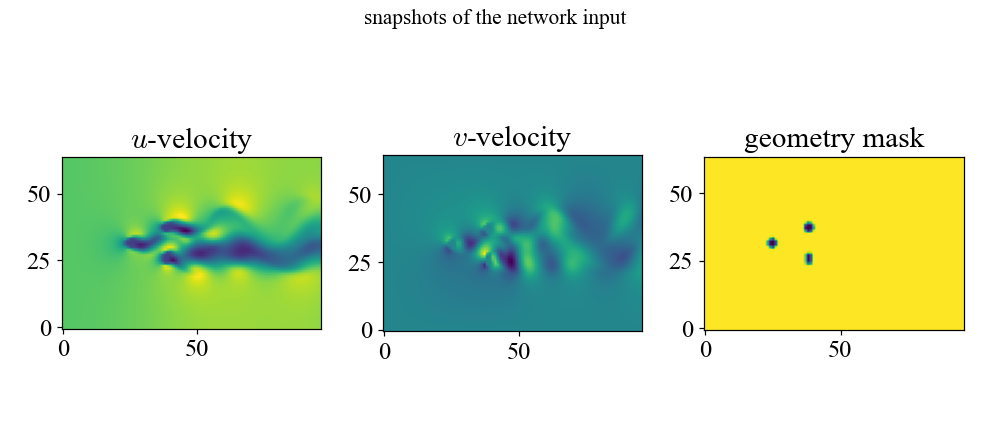

In [22]:
test_config = 75
tot_no_frames = 300

data_preloaded = load_test_sim(test_config,tot_no_frames)
source_mask_initial,source_vel_initial,obj_l,seq_l = load_initial_frame(data_preloaded,tot_no_frames)
steps_source = run_source(source_mask_initial, source_vel_initial, obj_l, seq_l,tot_no_frames)
steps_hybrid = run_sim(source_mask_initial, source_vel_initial, obj_l, seq_l,tot_no_frames,network)
mae_frameP, err_predP, uxP,vyP = calc_mae_frame(tot_no_frames-1,data_preloaded,steps_hybrid)
mae_frameS, err_predS, uxS,vyS = calc_mae_frame(tot_no_frames-1,data_preloaded,steps_source)

fig, axs = plt.subplots(1,3, figsize=(9,4))

fig.suptitle("snapshots of the network input", fontsize=14)
plot_stuff(source_vel_initial.vector[0].x[:].y[:].values.numpy(('batch','x','y'))[0,...], '$u$-velocity', 0,cap=0)
plot_stuff(source_vel_initial.vector[1].x[:].y[:].values.numpy(('batch','x','y'))[0,...], '$v$-velocity', 1,cap=0)
plot_stuff(source_mask_initial.x[:].y[:].values.numpy(('batch','x','y'))[0,...], 'geometry mask', 2,cap=0)

plt.tight_layout()

In [23]:
L = 24
H = 16
nx = 96
ny = 64

range_i = 15
range_e = 18
sub_frames = 100

delx = L/nx
dely = H/ny

probe_1x = 8 * (nx/L) - np.ceil(L_D[test_config]*dia1[test_config]*0.5*nx/L) + np.ceil(dia2[test_config]*1.2*nx/L)
probe_1y = 8 * (ny/H) 

probe_2x = 8 * (nx/L) + np.ceil(L_D[test_config]*dia1[test_config]*0.5*nx/L) + np.ceil(dia2[test_config]*1.2*nx/L)
probe_2y = 8 * (ny/H) + np.ceil(L_D[test_config]*dia1[test_config]*0.5*nx/L) 

probe_3x = 8 * (nx/L) + np.ceil(L_D[test_config]*dia1[test_config]*0.5*nx/L) + np.ceil(dia2[test_config]*1.2*nx/L)
probe_3y = 8 * (ny/H) - np.ceil(L_D[test_config]*dia1[test_config]*0.5*nx/L) 


print('Spatial probes: n_px1={}, n_py1={}, n_px2={}, n_py2={}, n_px3={}, n_py3={}'.format(probe_1x,probe_1y,probe_2x,probe_2y,probe_3x,probe_3y))

prefix = 'postProcessDir/test_config_' + str(test_config)+'/'

opt = 0
print_vel_mod(data_preloaded[sim_name[0]],opt,prefix,test_config,int(probe_1x),int(probe_1y),int(probe_2x),int(probe_2y),int(probe_3x),int(probe_3y))

opt = 1
print_vel_mod(steps_hybrid,opt,prefix,test_config,int(probe_1x),int(probe_1y),int(probe_2x),int(probe_2y),int(probe_3x),int(probe_3y))

opt = 2
print_vel_mod(steps_source,opt,prefix,test_config,int(probe_1x),int(probe_1y),int(probe_2x),int(probe_2y),int(probe_3x),int(probe_3y))



Spatial probes: n_px1=30.0, n_py1=32.0, n_px2=42.0, n_py2=38.0, n_px3=42.0, n_py3=26.0


In [24]:
arr_V = np.zeros([nx*ny,sub_frames*(range_e-range_i)+1])

opt = 0
SaveMeanV(data_preloaded[sim_name[0]],opt,prefix,test_config,arr_V)
SaveMeanVelStreamwise(data_preloaded[sim_name[0]],opt,prefix,test_config,arr_V)

opt = 1
SaveMeanV(steps_hybrid,opt,prefix,test_config,arr_V)
SaveMeanVelStreamwise(steps_hybrid,opt,prefix,test_config,arr_V)

opt = 2
SaveMeanV(steps_source,opt,prefix,test_config,arr_V)
SaveMeanVelStreamwise(steps_source,opt,prefix,test_config,arr_V)

In [66]:
#spatial probes
nx0 = 48
ny0 = 32

nx1 = 64
ny1 = 32

nx2 = 80
ny2 = 32

u_gt, v_gt, u_p, v_p, u_s, v_s = vel_probe(data_preloaded,steps_hybrid,steps_source, tot_no_frames, nx0, ny0)
u_gt1, v_gt1, u_p1, v_p1, u_s1, v_s1 = vel_probe(data_preloaded,steps_hybrid,steps_source, tot_no_frames, nx1, ny1)
u_gt2, v_gt2, u_p2, v_p2, u_s2, v_s2 = vel_probe(data_preloaded,steps_hybrid,steps_source, tot_no_frames, nx2, ny2)


<IPython.core.display.Javascript object>


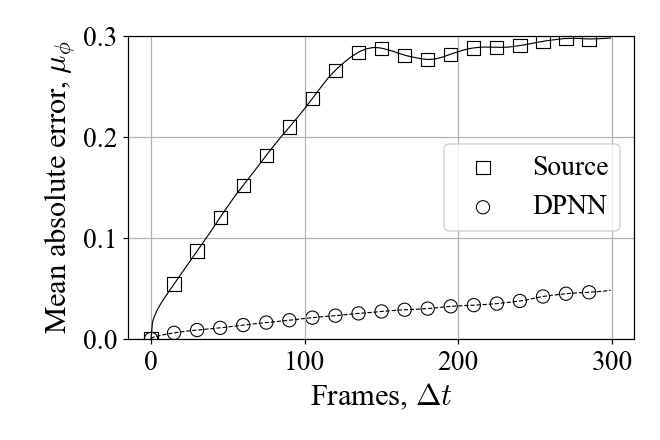

In [59]:
fig = plt.figure(figsize=(6,4))

lim_x = tot_no_frames

err_idx = np.arange(0,lim_x,1)
dx = 15

plt.plot(err_predS[0:lim_x],'k',linewidth=0.75,linestyle='solid')
plt.scatter(err_idx[::dx],err_predS[:lim_x:dx],marker='s',s=75,facecolors="none" , edgecolor = 'k',linewidth=0.75,label='Source')

plt.plot(err_predP[0:lim_x],'k',linewidth=0.75,linestyle='dashed')
plt.scatter(err_idx[::dx],err_predP[:lim_x:dx],marker='o',s=75,facecolors="none" , edgecolor = 'k',linewidth=0.7,label='DPNN')

plt.xlabel('Frames, $\Delta t$',fontsize=20)
plt.ylabel('Mean absolute error, $\mu_\mathrm{\phi}$',fontsize=20)
plt.tick_params(labelsize=18)

plt.ylim([0,0.3])

plt.legend(fontsize=18)
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


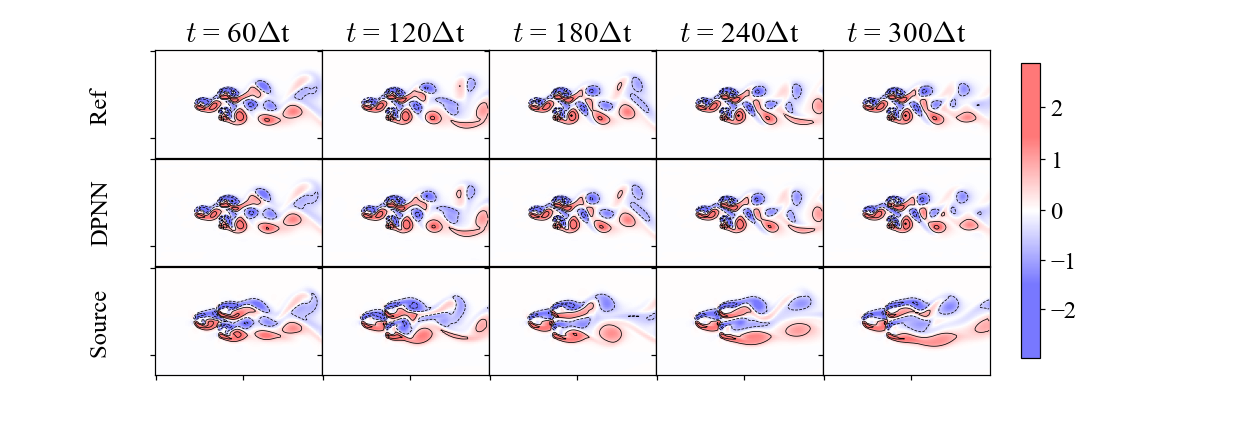

In [233]:
fig, axs = plt.subplots(3,5, figsize=(11.25,3.84))

frame_no = 59
velocity_GT, vorticity_GT = conv_vel_vort(data_preloaded[sim_name[0]][frame_no], 0)
velocity_s, vorticity_s = conv_vel_vort(steps_source[frame_no][1], 1)
velocity_p, vorticity_p = conv_vel_vort(steps_hybrid[frame_no][1], 1)


colBar = 0
contour = 0
col = 0
cp = 'colwarm'
lmax = -3
lmin = 3
labels = 6
vortContour(vorticity_GT, '$t$ = '+str(frame_no+1)+'$\Delta$t ', lmin,lmax,labels,0,col,colBar,contour)
vortContour(vorticity_s, '',lmin,lmax,labels,2,col,colBar,contour)
vortContour(vorticity_p, '',lmin,lmax,labels,1,col,colBar,contour)


frame_no = 119
velocity_GT, vorticity_GT = conv_vel_vort(data_preloaded[sim_name[0]][frame_no], 0)
velocity_s, vorticity_s = conv_vel_vort(steps_source[frame_no][1], 1)
velocity_p, vorticity_p = conv_vel_vort(steps_hybrid[frame_no][1], 1)

colBar = 0
contour = 0
col = 1
cp = 'RdBu'
vortContour(vorticity_GT, '$t$ = '+str(frame_no+1)+'$\Delta$t ', lmin,lmax,labels,0,col,colBar,contour)
vortContour(vorticity_s, '',lmin,lmax,labels,2,col,colBar,contour)
vortContour(vorticity_p, '',lmin,lmax,labels,1,col,colBar,contour)

frame_no = 179
velocity_GT, vorticity_GT = conv_vel_vort(data_preloaded[sim_name[0]][frame_no], 0)
velocity_s, vorticity_s = conv_vel_vort(steps_source[frame_no][1], 1)
velocity_p, vorticity_p = conv_vel_vort(steps_hybrid[frame_no][1], 1)


colBar = 0
contour = 0
col = 2
cp = 'RdBu'
vortContour(vorticity_GT, '$t$ = '+str(frame_no+1)+'$\Delta$t ', lmin,lmax,labels,0,col,colBar,contour)
vortContour(vorticity_s, '',lmin,lmax,labels,2,col,colBar,contour)
vortContour(vorticity_p, '',lmin,lmax,labels,1,col,colBar,contour)


frame_no = 239
velocity_GT, vorticity_GT = conv_vel_vort(data_preloaded[sim_name[0]][frame_no], 0)
velocity_s, vorticity_s = conv_vel_vort(steps_source[frame_no][1], 1)
velocity_p, vorticity_p = conv_vel_vort(steps_hybrid[frame_no][1], 1)


colBar = 0
contour = 0
col = 3
cp = 'RdBu'
vortContour(vorticity_GT, '$t$ = '+str(frame_no+1)+'$\Delta$t ', lmin,lmax,labels,0,col,colBar,contour)
vortContour(vorticity_s, '',lmin,lmax,labels,2,col,colBar,contour)
vortContour(vorticity_p, '',lmin,lmax,labels,1,col,colBar,contour)



frame_no = 299
velocity_GT, vorticity_GT = conv_vel_vort(data_preloaded[sim_name[0]][frame_no], 0)
velocity_s, vorticity_s = conv_vel_vort(steps_source[frame_no][1], 1)
velocity_p, vorticity_p = conv_vel_vort(steps_hybrid[frame_no][1], 1)


colBar = 0
contour = 0
col = 4
cp = 'RdBu'#'bwr'#'coolwarm' # viridis
vortContour(vorticity_GT, '$t$ = '+str(frame_no+1)+'$\Delta$t ', lmin,lmax,labels,0,col,colBar,contour)
vortContour(vorticity_s, '',lmin,lmax,labels,2,col,colBar,contour)
im = vortContour(vorticity_p, '',lmin,lmax,labels,1,col,colBar,contour)

axs[0,0].set_ylabel('Ref \n')
axs[1,0].set_ylabel('DPNN\n')
axs[2,0].set_ylabel('Source \n')


#plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.015, 0.7])
plt.set_cmap('seismic')
fig.colorbar(im, cax=cbar_ax)


<IPython.core.display.Javascript object>


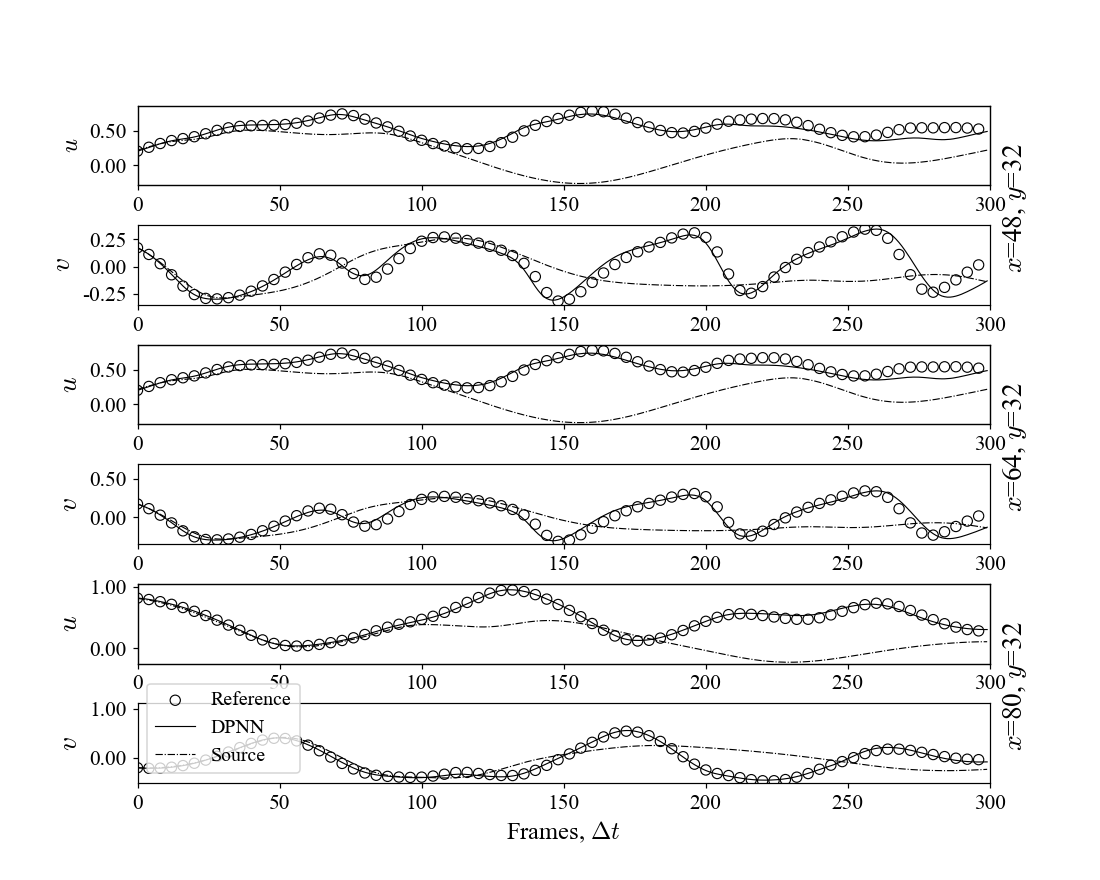

[]

In [234]:
fig,ax = plt.subplots(6, 1, figsize=(10,8))

u_tot = np.concatenate((u_gt,u_p,u_s), axis=None)
y_max = np.max(u_tot)
y_min = np.min(u_tot)

sep = 100

ax[0].scatter(np.arange(0,len(u_gt),4), u_gt[::4],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
ax[0].plot(np.arange(0,len(u_p)), u_p, 'k', label='DPNN',linewidth=0.75,linestyle='solid')
ax[0].plot(np.arange(0,len(u_s)), u_s, 'k', label='Source',linewidth=0.75,linestyle='dashdot')
ax[0].set_xlim([0, 300])

if y_min<0:
    ax[0].set_ylim([y_min*1.1, y_max*1.1])
if y_min>0:
    ax[0].set_ylim([y_min, y_max*1.1])


v_tot = np.concatenate((v_gt,v_p,v_s), axis=None)
y_max = np.max(v_tot)
y_min = np.min(v_tot)

ax[1].scatter(np.arange(0,len(v_gt),4), v_gt[::4],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
ax[1].plot(np.arange(0,len(v_p)), v_p, 'k', label='DPNN',linewidth=0.75,linestyle='solid')
ax[1].plot(np.arange(0,len(v_s)), v_s, 'k', label='Sou',linewidth=0.75,linestyle='dashdot')   
ax[1].set_xlim([0, 300])
    
if y_min<0:
    ax[1].set_ylim([y_min*1.1, y_max*1.1])
if y_min>0:
    ax[1].set_ylim([y_min*0.9, y_max*1.1])
    
    
u_tot = np.concatenate((u_gt1,u_p1,u_s1), axis=None)
y_max = np.max(u_tot)
y_min = np.min(u_tot)

ax[2].scatter(np.arange(0,len(u_gt1),4), u_gt1[::4],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
ax[2].plot(np.arange(0,len(u_p1)), u_p1, 'k', label='DPNN',linewidth=0.75,linestyle='solid')
ax[2].plot(np.arange(0,len(u_s1)), u_s1, 'k', label='Sou',linewidth=0.75,linestyle='dashdot')
ax[2].set_xlim([0, 300])

if y_min<0:
    ax[2].set_ylim([y_min*1.1, y_max*1.1])
if y_min>0:
    ax[2].set_ylim([y_min, y_max*1.1])
    
v_tot = np.concatenate((v_gt1,v_p1,v_s1), axis=None)
y_max = np.max(v_tot)
y_min = np.min(v_tot)


ax[3].scatter(np.arange(0,len(v_gt1),4), v_gt1[::4],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
ax[3].plot(np.arange(0,len(v_p1)), v_p1, 'k', label='DPNN',linewidth=0.75,linestyle='solid')
ax[3].plot(np.arange(0,len(v_s1)), v_s1, 'k', label='Sou',linewidth=0.75,linestyle='dashdot')
ax[3].set_xlim([0, 300])

if y_min<0:
    ax[3].set_ylim([y_min*1.1, y_max*2.0])
if y_min>0:
    ax[3].set_ylim([y_min*0.9, y_max*2.0])
    
u_tot = np.concatenate((u_gt2,u_p2,u_s2), axis=None)
y_max = np.max(u_tot)
y_min = np.min(u_tot)


ax[4].scatter(np.arange(0,len(u_gt2),4), u_gt2[::4],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
ax[4].plot(np.arange(0,len(u_p2)), u_p2, 'k', label='DPNN',linewidth=0.75,linestyle='solid')
ax[4].plot(np.arange(0,len(u_s2)), u_s2, 'k', label='Sou',linewidth=0.75,linestyle='dashdot')
ax[4].set_xlim([0, 300])

if y_min<0:
    ax[4].set_ylim([y_min*1.1, y_max*1.1])
if y_min>0:
    ax[4].set_ylim([y_min, y_max*1.1])
    
v_tot = np.concatenate((v_gt2,v_p2,v_s2), axis=None)
y_max = np.max(v_tot)
y_min = np.min(v_tot)

ax[5].scatter(np.arange(0,len(v_gt2),4), v_gt2[::4],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
ax[5].plot(np.arange(0,len(v_p2)), v_p2, 'k', label='DPNN',linewidth=0.75,linestyle='solid')
ax[5].plot(np.arange(0,len(v_s2)), v_s2, 'k', label='Source',linewidth=0.75,linestyle='dashdot')
ax[5].set_xlim([0, 300])

if y_min<0:
    ax[5].set_ylim([y_min*1.1, y_max*2.0])
if y_min>0:
    ax[5].set_ylim([y_min*0.9, y_max*2.0])
    
    
del u_tot
del v_tot

ax[0].set_ylabel(r'$u$',fontsize=16)
ax[1].set_ylabel(r'$v$',fontsize=18)
ax[2].set_ylabel(r'$u$',fontsize=18)
ax[3].set_ylabel(r'$v$',fontsize=18)
ax[4].set_ylabel(r'$u$',fontsize=18)
ax[5].set_ylabel(r'$v$',fontsize=18)

ax[5].set_xlabel('Frames, $\Delta t$',fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[3].tick_params(axis='both', which='major', labelsize=14)
ax[4].tick_params(axis='both', which='major', labelsize=14)
ax[5].tick_params(axis='both', which='major', labelsize=14)


plt.subplots_adjust(wspace=0, hspace=0.5)

ax[5].legend(bbox_to_anchor=(0,0), loc="lower left",prop = ticks_font)

y_labels = ax[0].get_yticks()
ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.02f'))

y_labels = ax[1].get_yticks()
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.02f'))

y_labels = ax[2].get_yticks()
ax[2].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.02f'))

y_labels = ax[3].get_yticks()
ax[3].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.02f'))

y_labels = ax[4].get_yticks()
ax[4].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.02f'))

y_labels = ax[5].get_yticks()
ax[5].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.02f'))

ax2 = ax[0].twinx()
ax2.set_ylabel('$x$=48, $y$=32                   ',fontsize=18)
ax2.set_yticks([])

ax2 = ax[2].twinx()
ax2.set_ylabel('$x$=64, $y$=32                   ',fontsize=18)
ax2.set_yticks([])

ax2 = ax[4].twinx()
ax2.set_ylabel('$x$=80, $y$=32                   ',fontsize=18)
ax2.set_yticks([])


<IPython.core.display.Javascript object>


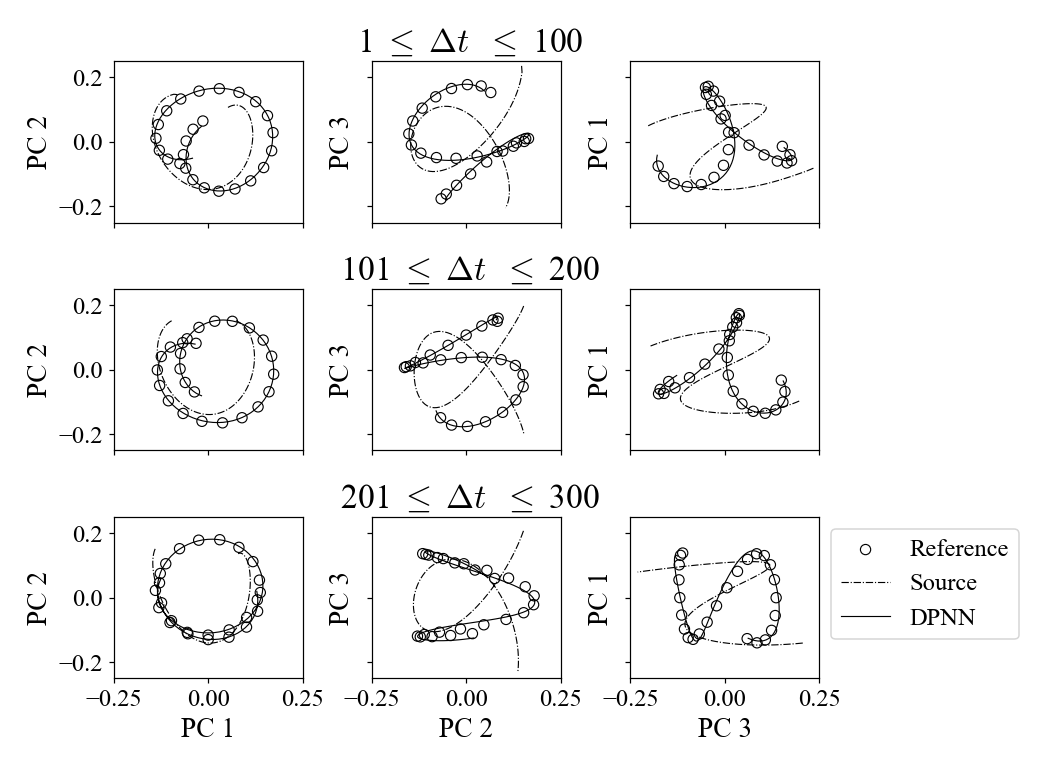

In [83]:
fig, axs = plt.subplots(3,3,figsize=(9.5,7))

frame_i = 0
frame_e = 100
modes = [0,1,2]

al_gt = PCA_calc(data_preloaded[sim_name[0]], frame_e, frame_i,0)

axs[0,0].scatter(al_gt[::4,modes[0]],al_gt[::4,modes[1]],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
axs[0,1].scatter(al_gt[::4,modes[1]],al_gt[::4,modes[2]],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
axs[0,2].scatter(al_gt[::4,modes[2]],al_gt[::4,modes[0]],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')

al_s = PCA_calc(steps_source, frame_e, frame_i,1)

for i in range(len(modes)):
    if al_gt[0,i]<0 and al_s[0,i]>0:
        al_s[:,i] = al_s[:,i] * -1

    elif al_gt[0,i]>0 and al_s[0,i]<0:
        al_s[:,i] = al_s[:,i] * -1

axs[0,0].plot(al_s[:,modes[0]],al_s[:,modes[1]],'k',linestyle='dashdot',linewidth=0.75)
axs[0,1].plot(al_s[:,modes[1]],al_s[:,modes[2]],'k',linestyle='dashdot',linewidth=0.75)
axs[0,2].plot(al_s[:,modes[2]],al_s[:,modes[0]],'k',  label='Source',linestyle='dashdot',linewidth=0.75)

al_p = PCA_calc(steps_hybrid, frame_e, frame_i,1)

for i in range(len(modes)):
    if al_gt[0,i]<0 and al_p[0,i]>0:
        al_p[:,i] = al_p[:,i] * -1

    elif al_gt[0,i]>0 and al_p[0,i]<0:
        al_p[:,i] = al_p[:,i] * -1


axs[0,0].plot(al_p[:,modes[0]],al_p[:,modes[1]],'k',linewidth=0.75,linestyle='solid')
axs[0,1].plot(al_p[:,modes[1]],al_p[:,modes[2]],'k',linewidth=0.75,linestyle='solid')
axs[0,2].plot(al_p[:,modes[2]],al_p[:,modes[0]],'k', label='DPNN',linewidth=0.75,linestyle='solid')

axs[0,1].set_title(' 1 $\leq$ $\Delta t$  $\leq$ 100', fontsize=22)

axs[0,0].set_ylabel('PC '+str(modes[1]+1), fontsize=18)
axs[0,1].set_ylabel('PC '+str(modes[2]+1), fontsize=18)
axs[0,2].set_ylabel('PC '+str(modes[0]+1), fontsize=18)

axs[0,0].xaxis.set_ticklabels([]) 

axs[0,1].xaxis.set_ticklabels([]) 
axs[0,1].yaxis.set_ticklabels([]) 

axs[0,2].xaxis.set_ticklabels([]) 
axs[0,2].yaxis.set_ticklabels([])  


frame_i = 100
frame_e = 200
modes = [0,1,2]

al_gt = PCA_calc(data_preloaded[sim_name[0]], frame_e, frame_i,0)

axs[1,0].scatter(al_gt[::4,modes[0]],al_gt[::4,modes[1]],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
axs[1,1].scatter(al_gt[::4,modes[1]],al_gt[::4,modes[2]],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
axs[1,2].scatter(al_gt[::4,modes[2]],al_gt[::4,modes[0]],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')

al_s = PCA_calc(steps_source, frame_e, frame_i,1)

for i in range(len(modes)):
    if al_gt[0,i]<0 and al_s[0,i]>0:
        al_s[:,i] = al_s[:,i] * -1

    elif al_gt[0,i]>0 and al_s[0,i]<0:
        al_s[:,i] = al_s[:,i] * -1

axs[1,0].plot(al_s[:,modes[0]],al_s[:,modes[1]],'k',linestyle='dashdot',linewidth=0.75)
axs[1,1].plot(al_s[:,modes[1]],al_s[:,modes[2]],'k',linestyle='dashdot',linewidth=0.75)
axs[1,2].plot(al_s[:,modes[2]],al_s[:,modes[0]],'k',  label='Source',linestyle='dashdot',linewidth=0.75)

al_p = PCA_calc(steps_hybrid, frame_e, frame_i,1)

for i in range(len(modes)):
    if al_gt[0,i]<0 and al_p[0,i]>0:
        al_p[:,i] = al_p[:,i] * -1

    elif al_gt[0,i]>0 and al_p[0,i]<0:
        al_p[:,i] = al_p[:,i] * -1


axs[1,0].plot(al_p[:,modes[0]],al_p[:,modes[1]],'k',linewidth=0.75,linestyle='solid')
axs[1,1].plot(al_p[:,modes[1]],al_p[:,modes[2]],'k',linewidth=0.75,linestyle='solid')
axs[1,2].plot(al_p[:,modes[2]],al_p[:,modes[0]],'k', label='DPNN',linewidth=0.75,linestyle='solid')

axs[1,1].set_title(' 101 $\leq$ $\Delta t$  $\leq$ 200', fontsize=22)

axs[1,0].set_ylabel('PC '+str(modes[1]+1), fontsize=18)
axs[1,1].set_ylabel('PC '+str(modes[2]+1), fontsize=18)
axs[1,2].set_ylabel('PC '+str(modes[0]+1), fontsize=18)

axs[1,0].xaxis.set_ticklabels([]) 

axs[1,1].xaxis.set_ticklabels([]) 
axs[1,1].yaxis.set_ticklabels([]) 

axs[1,2].xaxis.set_ticklabels([]) 
axs[1,2].yaxis.set_ticklabels([])  


frame_i = 200
frame_e = 300
modes = [0,1,2]

al_gt = PCA_calc(data_preloaded[sim_name[0]], frame_e, frame_i,0)

axs[2,0].scatter(al_gt[::4,modes[0]],al_gt[::4,modes[1]],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
axs[2,1].scatter(al_gt[::4,modes[1]],al_gt[::4,modes[2]],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
axs[2,2].scatter(al_gt[::4,modes[2]],al_gt[::4,modes[0]],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')

al_s = PCA_calc(steps_source, frame_e, frame_i,1)

for i in range(len(modes)):
    if al_gt[0,i]<0 and al_s[0,i]>0:
        al_s[:,i] = al_s[:,i] * -1

    elif al_gt[0,i]>0 and al_s[0,i]<0:
        al_s[:,i] = al_s[:,i] * -1

axs[2,0].plot(al_s[:,modes[0]],al_s[:,modes[1]],'k',linestyle='dashdot',linewidth=0.75)
axs[2,1].plot(al_s[:,modes[1]],al_s[:,modes[2]],'k',linestyle='dashdot',linewidth=0.75)
axs[2,2].plot(al_s[:,modes[2]],al_s[:,modes[0]],'k',linestyle='dashdot',  label='Source',linewidth=0.75)

al_p = PCA_calc(steps_hybrid, frame_e, frame_i,1)

for i in range(len(modes)):
    if al_gt[0,i]<0 and al_p[0,i]>0:
        al_p[:,i] = al_p[:,i] * -1

    elif al_gt[0,i]>0 and al_p[0,i]<0:
        al_p[:,i] = al_p[:,i] * -1


axs[2,0].plot(al_p[:,modes[0]],al_p[:,modes[1]],'k',linewidth=0.75,linestyle='solid')
axs[2,1].plot(al_p[:,modes[1]],al_p[:,modes[2]],'k',linewidth=0.75,linestyle='solid')
axs[2,2].plot(al_p[:,modes[2]],al_p[:,modes[0]],'k', label='DPNN',linewidth=0.75,linestyle='solid')

axs[2,1].set_title(' 201 $\leq$ $\Delta t$  $\leq$ 300', fontsize=22)


axs[2,0].set_xlabel('PC '+str(modes[0]+1), fontsize=18)
axs[2,0].set_ylabel('PC '+str(modes[1]+1), fontsize=18)
axs[2,1].set_xlabel('PC '+str(modes[1]+1), fontsize=18)
axs[2,1].set_ylabel('PC '+str(modes[2]+1), fontsize=18)
axs[2,2].set_xlabel('PC '+str(modes[2]+1), fontsize=18)
axs[2,2].set_ylabel('PC '+str(modes[0]+1), fontsize=18)

axs[2,1].yaxis.set_ticklabels([]) 

axs[2,2].yaxis.set_ticklabels([])  

axs[2,2].legend(bbox_to_anchor=(1, 1))

custom_xlim = (-0.25, 0.25)
custom_ylim = (-0.25, 0.25)

plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)

plt.tight_layout()



<IPython.core.display.Javascript object>


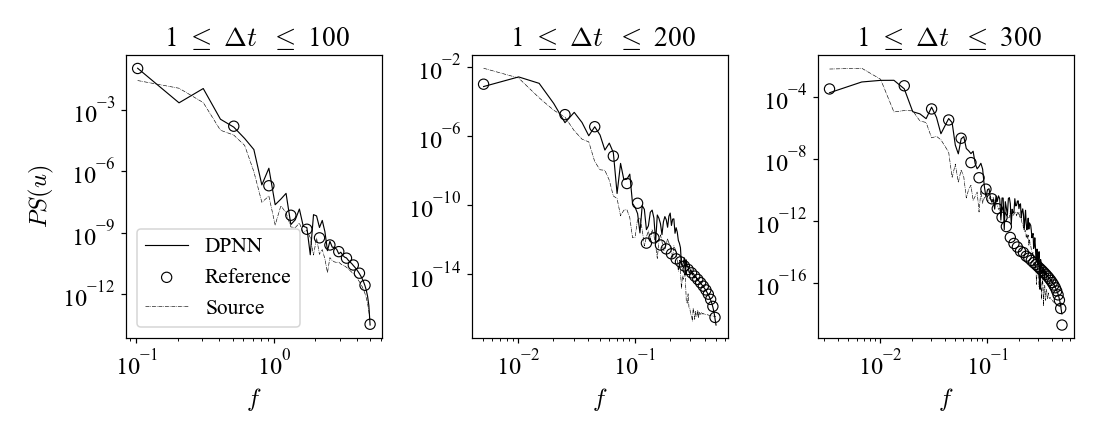

In [88]:
eval_frames = 100

start = 1500
end = start+eval_frames

nx1 = 64
ny1 = 32

u_gt, v_gt, u_p, v_p, u_s, v_s = vel_probe(data_preloaded,steps_hybrid,steps_source, eval_frames, nx1, ny1)

t = np.arange(0,0.1*(end-start),.1)

fr1, ur1 = freq_spectra(t, np.asarray(u_gt).squeeze())
fr2, ur2 = freq_spectra(t, u_p)
fr3, ur3 = freq_spectra(t, u_s)

fig, ax = plt.subplots(1,3,figsize=(10,4.0))

ax[0].loglog(fr2,ur2,c='k',linewidth=0.75,linestyle='solid',label='DPNN')
ax[0].scatter(fr1[::4],ur1[::4],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75,label='Reference')
ax[0].loglog(fr3,ur3,c='k',linewidth=0.4,linestyle='dashdot',label='Source')
ax[0].set_xlabel(r'$f$', fontsize=16)
ax[0].set_ylabel(r'$PS(u)$', fontsize=16)
ax[0].set_title(' 1 $\leq$ $\Delta t$  $\leq$ 100', fontsize=18)
ax[0].legend(loc='lower left',prop={'size': 14})

eval_frames = 200

start = 1500
end = start+eval_frames

nx1 = 64
ny1 = 32

u_gt, v_gt, u_p, v_p, u_s, v_s = vel_probe(data_preloaded,steps_hybrid,steps_source, eval_frames, nx1, ny1)

t = np.arange(0,end-start,1)

fr1, ur1 = freq_spectra(t, np.asarray(u_gt).squeeze())
fr2, ur2 = freq_spectra(t, u_p)
fr3, ur3 = freq_spectra(t, u_s)

ax[1].loglog(fr2,ur2,c='k',linewidth=0.75,linestyle='solid')
ax[1].scatter(fr1[::4],ur1[::4],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75)
ax[1].loglog(fr3,ur3,c='k',linewidth=0.4,linestyle='dashdot')

ax[1].set_xlabel(r'$f$', fontsize=16)
ax[1].set_title(' 1 $\leq$ $\Delta t$  $\leq$ 200', fontsize=18)

eval_frames = 300

start = 1500
end = start+eval_frames

nx1 = 64
ny1 = 32

u_gt, v_gt, u_p, v_p, u_s, v_s = vel_probe(data_preloaded,steps_hybrid,steps_source, eval_frames, nx1, ny1)

t = np.arange(0,end-start,1)

fr1, ur1 = freq_spectra(t, np.asarray(u_gt).squeeze())
fr2, ur2 = freq_spectra(t, u_p)
fr3, ur3 = freq_spectra(t, u_s)

ax[2].loglog(fr2,ur2,c='k',linewidth=0.75,linestyle='solid')
ax[2].scatter(fr1[::4],ur1[::4],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75)
ax[2].loglog(fr3,ur3,c='k',linewidth=0.4,linestyle='dashdot')
ax[2].set_xlabel(r'$f$', fontsize=16)
ax[2].set_title(' 1 $\leq$ $\Delta t$  $\leq$ 300', fontsize=18)

plt.tight_layout()


<IPython.core.display.Javascript object>


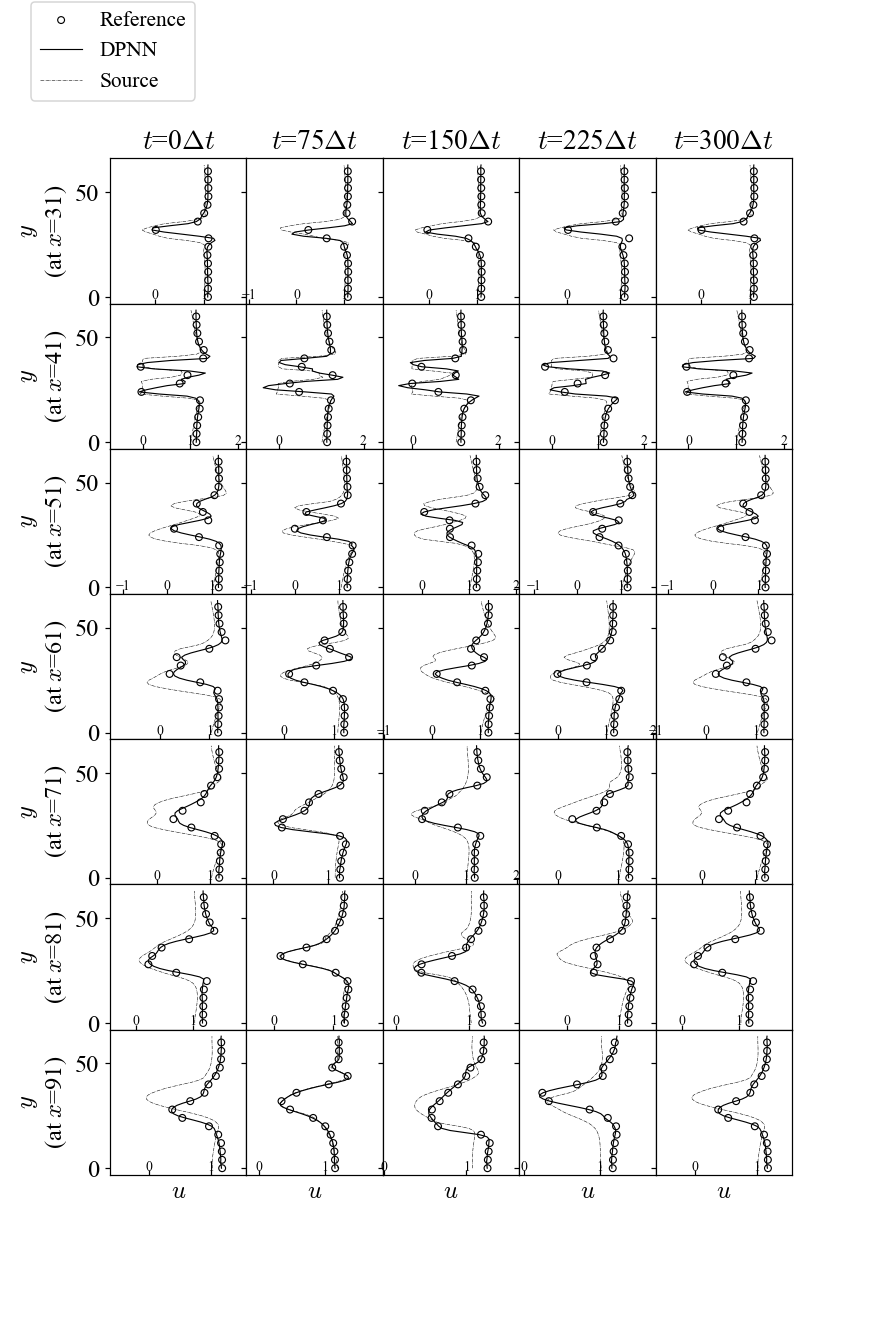

In [96]:
layers = np.arange(1,nx,10)
lx = 5

fig, axs = plt.subplots(len(layers)-3,lx,figsize=(8,12))

n = 300
skip = int(n/(lx-1))

l=0
for k in range(0,n+1,skip):
    
    for j in range(0,len(layers)-3,1):
        
        loc = j+3

        time_frame = k-1
        err_hyb, err_sou, vx_ref, vx_hyb, vx_src = calc_err(time_frame)

        ref_v = vx_ref[0][:,int(layers[loc])]    
        hyb_v = vx_hyb[:,int(layers[loc])]
        src_v = vx_src[:,int(layers[loc])]
        

        if k==0 & j==0:
            axs[j,l].scatter(ref_v[::4], range(len(ref_v))[::4],marker='o',s=20,facecolors="none" , edgecolor = 'k',linewidth=0.75,label='Reference')
            axs[j,l].plot(hyb_v, range(len(hyb_v)),color='k',linewidth=0.75,linestyle='solid',label='DPNN')
            axs[j,l].plot(src_v, range(len(src_v)),color='k',linewidth=0.35,linestyle='dashdot',label='Source')
        else:
            axs[j,l].scatter(ref_v[::4], range(len(ref_v))[::4],marker='o',s=20,facecolors="none" , edgecolor = 'k',linewidth=0.75)
            axs[j,l].plot(hyb_v, range(len(hyb_v)),color='k',linewidth=0.75,linestyle='solid')
            axs[j,l].plot(src_v, range(len(src_v)),color='k',linewidth=0.35,linestyle='dashdot')
            
 
        axs[0,0].legend(bbox_to_anchor=(0.7,2.15),fontsize='medium',loc='best',prop={'size': 14})
            
        axs[j,1].set_yticklabels([])
        axs[j,2].set_yticklabels([])
        axs[j,3].set_yticklabels([])
        axs[j,4].set_yticklabels([])

        axs[j,0].set_ylabel('$y$ \n(at $x$=' + str(int(layers[loc]))+')', fontsize=16)
                
        axs[j,l].set_xlim(src_v.min() - (src_v.max() -src_v.min())/2, hyb_v.max() + (hyb_v.max() -hyb_v.min())/2)
        axs[j,l].tick_params(axis="x",direction="in", pad=-10,labelsize=9)


        axs[6,0].set_xlabel(r'$u$', fontsize=16)
        axs[6,1].set_xlabel(r'$u$', fontsize=16)
        axs[6,2].set_xlabel(r'$u$', fontsize=16)
        axs[6,3].set_xlabel(r'$u$', fontsize=16)
        axs[6,4].set_xlabel(r'$u$', fontsize=16)
        
        axs[0,l].set_title('$t$='+str(k) +'$\Delta t$', fontsize=18)   
 
    if l<lx-1:
        l+=1

#plt.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout()



<IPython.core.display.Javascript object>


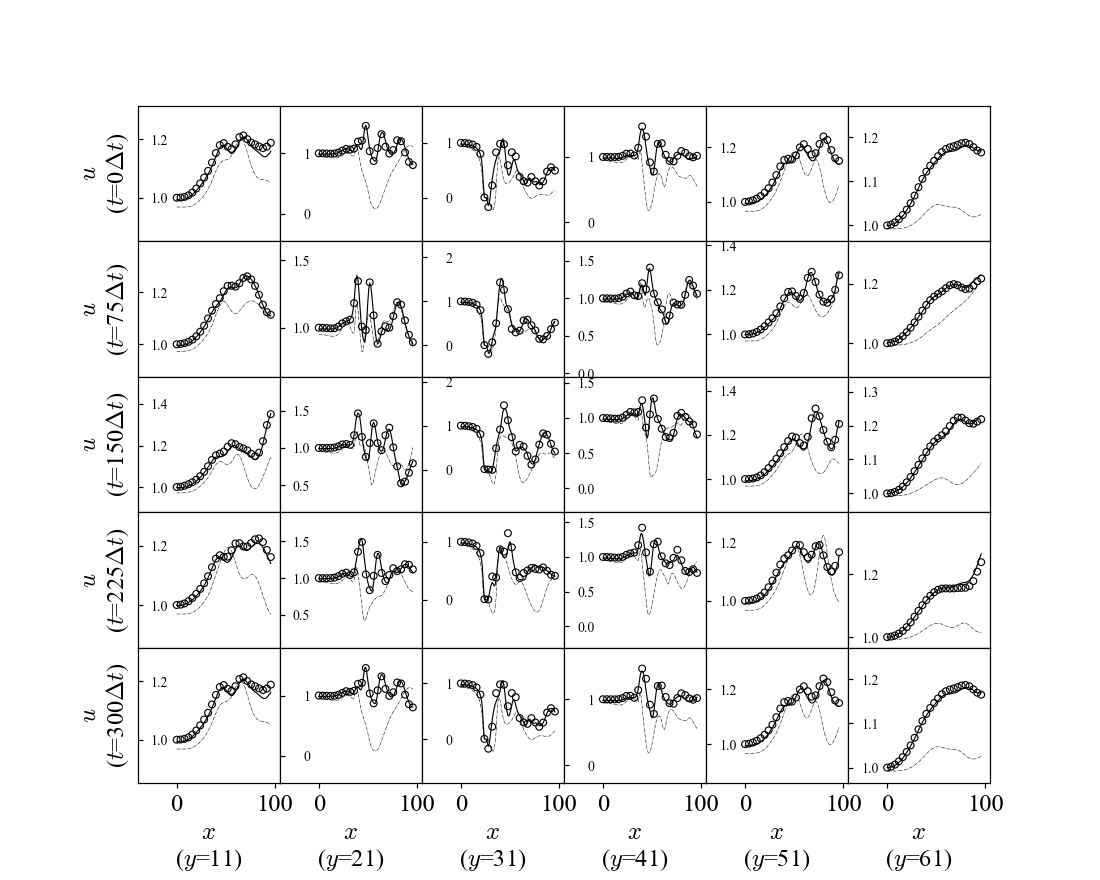

In [97]:
layers = np.arange(1,ny,10)
ly = 5

fig, axs = plt.subplots(ly,len(layers)-1,figsize=(10,8))

n = 300
skip = int(n/(ly-1))

l=0

for k in range(0,n+1,skip):
    for j in range(0,len(layers)-1,1):
    
        loc = j+1

        time_frame = k-1
        err_hyb, err_sou, vx_ref, vx_hyb, vx_src = calc_err(time_frame)

        ref_v = vx_ref[0][int(layers[loc]),:]
        hyb_v = vx_hyb[int(layers[loc]),:]
        src_v = vx_src[int(layers[loc]),:]

        axs[l,j].set_ylim(src_v.min() - (src_v.max() -src_v.min())/2, hyb_v.max() + (hyb_v.max() -hyb_v.min())/2)
       
        if k==0 & j==0:
            axs[l,j].scatter(range(len(ref_v))[::4],ref_v[::4],marker='o',s=20,facecolors="none" , edgecolor = 'k',linewidth=0.75,label='Reference')
            axs[l,j].plot(range(len(hyb_v)),hyb_v,color='k',linestyle='solid',linewidth=0.75,label='DPNN')
            axs[l,j].plot(range(len(src_v)),src_v,color='k',linestyle='dashdot',linewidth=0.35,label='Source')
        else:
            axs[l,j].scatter(range(len(ref_v))[::4],ref_v[::4],marker='o',s=20,facecolors="none" , edgecolor = 'k',linewidth=0.75,label='Reference')
            axs[l,j].plot(range(len(hyb_v)),hyb_v,color='k',linestyle='solid',linewidth=0.75)
            axs[l,j].plot(range(len(src_v)),src_v,color='k',linestyle='dashdot',linewidth=0.35)
            
        axs[0,j].set_xlim([-40,105])
        axs[1,j].set_xlim([-40,105])
        axs[2,j].set_xlim([-40,105])
        axs[3,j].set_xlim([-40,105])
        axs[4,j].set_xlim([-40,105])
        
        axs[0,j].set_xticklabels([])
        axs[1,j].set_xticklabels([])
        axs[2,j].set_xticklabels([])
        axs[3,j].set_xticklabels([])        
        
        axs[4,j].set_xlabel('$x$ \n($y$='+str(int(layers[loc]))+')', fontsize=16) 
        
        axs[l,0].set_ylabel('$u$ \n($t$='+str(k)+'$\Delta t$)', fontsize=16)

        axs[l,j].tick_params(axis="y",direction="in", pad=-20,labelsize=9)
        
    if l<ly-1:
        l+=1        

#plt.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout()


<IPython.core.display.Javascript object>


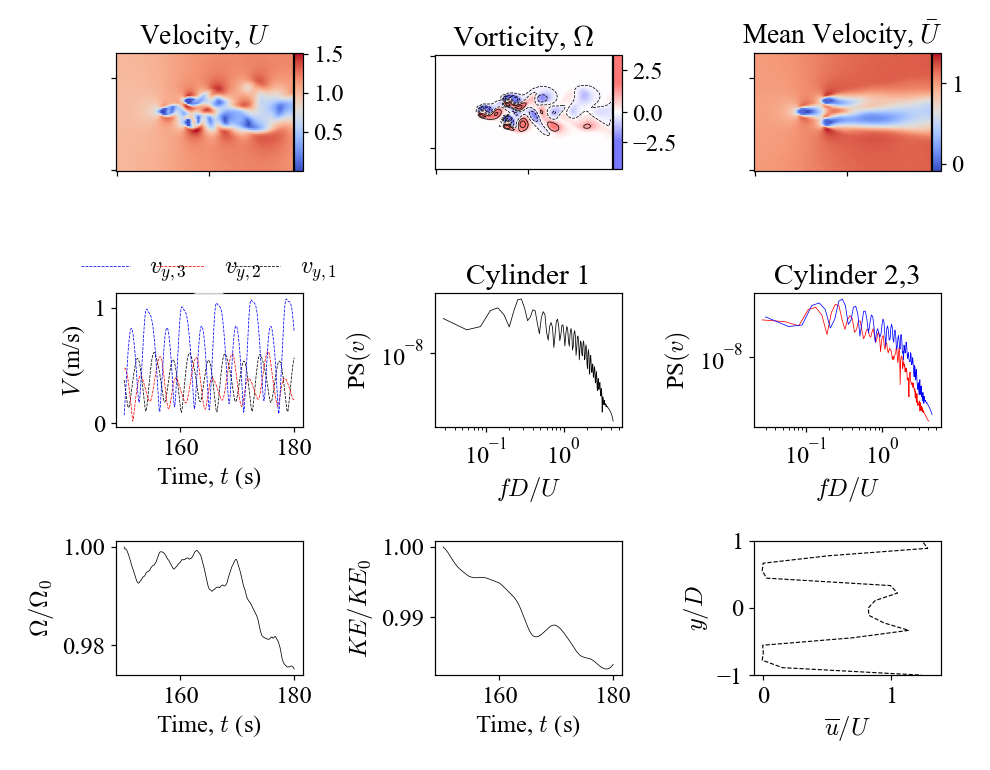

In [183]:
start = range_i*sub_frames
end = range_e*sub_frames
frame = 99
col = 2


flowfield=steps_hybrid
fName = prefix + str(test_config)+'_pred_FRange_'+str(range_i)+'_'+str(range_e) +  '/meanVelStreamwise.dat'
velocity, vorticity = conv_vel_vort(flowfield[frame][1], 1)

mean_V = np.loadtxt(fName, delimiter = " ", skiprows=0)
Mfield = np.reshape(mean_V, (nx,ny))

vel1, vel2, vel3, ens, KE = load_vel_prop(prefix,test_config,start,end,col,opt)

time = np.arange((start+1)*DT,(end+1)*DT,DT)

fr1, ur1 = freq_spectra(time, vel1)
fr2, ur2 = freq_spectra(time, vel2)
fr3, ur3 = freq_spectra(time, vel3)
U = 1.0

fr1 = fr1*dia1[test_config]/U
fr2 = fr2*dia2[test_config]/U
fr3 = fr3*dia3[test_config]/U


slX = int(np.ceil(( (L_D[test_config]*dia1[test_config]*0.5) + 8 ) / (L/nx)))
slY2 = int(np.ceil(( (L_D[test_config]*dia1[test_config]*0.5) - ((dia2[test_config])*0.5) + 8) / (H/ny)))
slY3 = int(np.floor(( 8- (L_D[test_config]*dia1[test_config]*0.5) + ((dia3[test_config])*0.5) ) / (H/ny)))

slcV, gx, gy = velMeanBL(Mfield,slX+0,nx,ny)
slcV = slcV.flatten()

fig, axs = plt.subplots(3,3, figsize=(9,7))

axs[0,0].set_title(r'Velocity, $U$', fontsize=18)
im = axs[0,0].imshow(np.transpose(velocity.numpy(('x','y'))), origin = 'lower', cmap='coolwarm')
axs[0,0].xaxis.set_ticklabels([])
axs[0,0].yaxis.set_ticklabels([])
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical')


im = vortContour(vorticity_GT, 'Vorticity, $\Omega$', 1,-1,8,0,1,0,0)
axs[0,1].xaxis.set_ticklabels([])
axs[0,1].yaxis.set_ticklabels([])
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical')


axs[0,2].set_title(r'Mean Velocity, $\bar{U}$', fontsize=18)
im = axs[0,2].imshow(np.transpose(Mfield), origin = 'lower', cmap='coolwarm')
axs[0,2].xaxis.set_ticklabels([])
axs[0,2].yaxis.set_ticklabels([])
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('right', size='5%', pad=0.01)
fig.colorbar(im, cax=cax, orientation='vertical')


axs[1,0].plot(time,vel1[0:end+1-start],c='k',linestyle='dashed',linewidth=0.5,label='$v_{y,1}$');
axs[1,0].plot(time,vel2[0:end+1-start],c='r',linestyle='dashed',linewidth=0.5,label='$v_{y,2}$');
axs[1,0].plot(time,vel3[0:end+1-start],c='b',linestyle='dashed',linewidth=0.5,label='$v_{y,3}$');
axs[1,0].set_xlabel('Time, $t$ (s)')
axs[1,0].set_ylabel('$V$ (m/s)')
leg = axs[1,0].legend(loc='best',bbox_to_anchor=(0.5,0.9), mode = "expand", ncol = 3)
leg.get_frame().set_linewidth(0.0)

axs[1,1].loglog(fr1,ur1,"k",  linewidth=0.5)
axs[1,1].set_xlabel("$fD/U$")
axs[1,1].set_ylabel("PS$(v)$")
axs[1,1].set_title("Cylinder 1")

axs[1,2].loglog(fr2,ur2,"r", linewidth=0.5)
axs[1,2].loglog(fr3,ur3,"b", linewidth=0.5)
axs[1,2].set_title("Cylinder 2,3")
axs[1,2].set_xlabel("$fD/U$")
axs[1,2].set_ylabel("PS$(v)$")


axs[2,0].plot(time,ens[0:end+1-start],c='k',linewidth=0.5,label='Enstrophy, \Omega$');
axs[2,0].set_xlabel('Time, $t$ (s)')
axs[2,0].set_ylabel('$\Omega/ \Omega_{\mathrm{0}} $')

axs[2,1].plot(time,KE[0:end+1-start],c='k',linewidth=0.5,label='$KE$');
axs[2,1].set_xlabel('Time, $t$ (s)')
axs[2,1].set_ylabel('$KE/ KE_{\mathrm{0}} $')

midY = 8

gy = gy - midY
dgy = abs(gy[slY2]- gy[slY3])
gy = gy/dgy


axs[2,2].plot(slcV, gy,linewidth=0.75, linestyle='dashed', c='k',label=r'$\bar{U}_G$')
axs[2,2].set_ylim(-1.0,1.0)
axs[2,2].set_xlabel('$\overline{u}/U$')
axs[2,2].set_ylabel('$y/D$')
#axs[2,2].legend()

plt.tight_layout()

filePath = prefix + 'MGlobalData_Pred.dat'

GData = []
GData.append(np.mean(ens))
GData.append(np.mean(KE))


np.savetxt(filePath,GData)

<IPython.core.display.Javascript object>


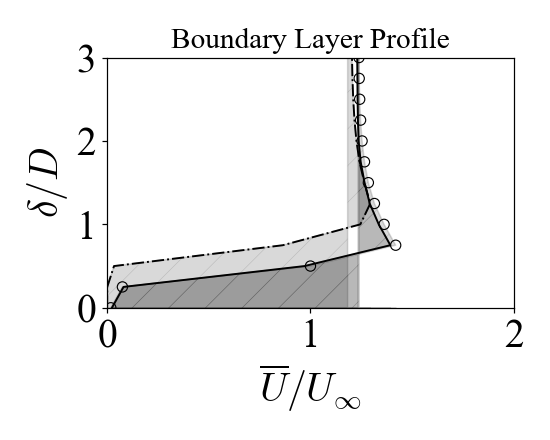

In [187]:

slX = int(np.ceil(( 8 - (L_D[test_config]*dia1[test_config]*0.5) ) / (L/nx)))

el = -1 # higher value > 0 indicate downstream of the centerline to probe at positions where BL growth has taken place

fNameGT = prefix + str(test_config)+'_GT_FRange_'+str(range_i)+'_'+str(range_e) + '/meanVel.dat'
mean_GT = np.loadtxt(fNameGT, delimiter = " ", skiprows=0)
MfieldGT = np.reshape(mean_GT, (nx,ny))

fNameS = prefix + str(test_config)+'_source_FRange_'+str(range_i)+'_'+str(range_e) +  '/meanVel.dat'
mean_S = np.loadtxt(fNameS, delimiter = " ", skiprows=0)
MfieldS = np.reshape(mean_S, (nx,ny))
    
fNameP = prefix + str(test_config)+'_pred_FRange_'+str(range_i)+'_'+str(range_e) +  '/meanVel.dat'
mean_P = np.loadtxt(fNameP, delimiter = " ", skiprows=0)
MfieldP = np.reshape(mean_P, (nx,ny))

slcGT, gxg, gyg  = velMeanBL2(MfieldGT,slX+el,nx,ny)
slcS, gxs, gys  = velMeanBL2(MfieldS,slX+el,nx,ny)
slcP, gxp, gyp  = velMeanBL2(MfieldP,slX+el,nx,ny)


slcGT = slcGT/dia1[test_config]
slcS = slcS/dia1[test_config]
slcP = slcP/dia1[test_config]

gyg = gyg-min(gyg)
gys = gys-min(gys)
gyp = gyp-min(gyp)

slcGT = slcGT.reshape(len(slcGT), )
slcP = slcP.reshape(len(slcP), )
slcS = slcS.reshape(len(slcS), )

divyg = np.ones(len(gyg)) * (gyg[1]-gyg[0])
divys = np.ones(len(gys)) * (gys[1]-gys[0])
divyp = np.ones(len(gyp)) * (gyp[1]-gyp[0])

momGT = MomT(np.divide(slcGT, max(slcGT)), 1 - (np.divide(slcGT, max(slcGT))), gyg)
momS = MomT(np.divide(slcS, max(slcS)), 1 - (np.divide(slcS, max(slcS))), gys)
momP = MomT(np.divide(slcP, max(slcP)), 1 - (np.divide(slcP, max(slcP))), gyp)

MvalGT = np.ones(len(gyg))*momGT
MvalS = np.ones(len(gys))*momS
MvalP = np.ones(len(gyp))*momP



fig = plt.figure(figsize=(5,4))

plt.scatter(slcGT, gyg,marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
plt.plot(slcS,gys, 'k', linewidth=1.25, linestyle='dashdot', label='Source')
plt.plot(slcP,gyp, 'k', linewidth=1.25, linestyle='solid', label='DPNN')

plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='both', which='minor', labelsize=26)

plt.fill_between(slcGT, 0, gyg, alpha=0.15, hatch='/',color='k')
plt.fill_between(slcS, 0, gyg, alpha=0.15, hatch='/',color='k')
plt.fill_between(slcP, 0, gyg, alpha=0.15, hatch='/',color='k')

plt.title('Boundary Layer Profile')
plt.xlabel('$\overline{U}/U_{\mathrm{\infty}}$',fontsize=26)
plt.ylabel('$\delta /D$',fontsize=26)
plt.ylim([0.0,3])
plt.xlim([0,2])

plt.tight_layout()

filePath = prefix + 'BL_data_bw.dat'

blData = []
blData.append(momGT)
blData.append(momS)
blData.append(momP)
np.savetxt(filePath,blData)

<IPython.core.display.Javascript object>


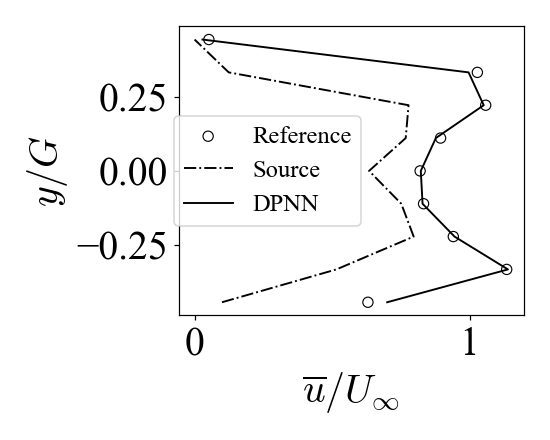

In [248]:
slX1 = int(np.ceil(( (L_D[test_config]*dia1[test_config]*0.5) + 8 ) / (L/nx)))
slY2 = int(np.ceil(( (L_D[test_config]*dia1[test_config]*0.5) - ((dia2[test_config])*0.5) + 8) / (H/ny)))
slY3 = int(np.floor(( 8- (L_D[test_config]*dia1[test_config]*0.5) + ((dia3[test_config])*0.5) ) / (H/ny)))

fNameGT = prefix + str(test_config)+'_GT_FRange_'+str(range_i)+'_'+str(range_e) +  '/meanVelStreamwise.dat'
mean_GT = np.loadtxt(fNameGT, delimiter = " ", skiprows=0)
MfieldGT = np.reshape(mean_GT, (nx,ny))

fNameS = prefix + str(test_config)+'_source_FRange_'+str(range_i)+'_'+str(range_e) +  '/meanVelStreamwise.dat'
mean_S = np.loadtxt(fNameS, delimiter = " ", skiprows=0)
MfieldS = np.reshape(mean_S, (nx,ny))
    
fNameP = prefix + str(test_config)+'_pred_FRange_'+str(range_i)+'_'+str(range_e) +  '/meanVelStreamwise.dat'
mean_P = np.loadtxt(fNameP, delimiter = " ", skiprows=0)
MfieldP = np.reshape(mean_P, (nx,ny))


slcGT, gx, gy  = velMeanBL(MfieldGT,slX1-0,nx,ny)
slcS, gx, gy  = velMeanBL(MfieldS,slX1-0,nx,ny)
slcP, gx, gy  = velMeanBL(MfieldP,slX1-0,nx,ny)

slcGT = slcGT.reshape(len(slcGT), )
slcP = slcP.reshape(len(slcP), )
slcS = slcS.reshape(len(slcS), )


fig = plt.figure(figsize=(5,4))

midY = 8

gy = gy - midY
dgy = abs(gy[slY2]- gy[slY3])
gy = gy/dgy

Uinf = 1.0
peaks, _ = find_peaks( slcGT[slY3:slY2],height=0.5)

plt.scatter(slcGT[slY3:slY2], gy[slY3:slY2],marker='o',s=45,facecolors="none" , edgecolor = 'k',linewidth=0.75, label='Reference')
plt.plot(slcS[slY3:slY2], gy[slY3:slY2], 'k', linewidth=1.25, linestyle='dashdot', label='Source')
plt.plot(slcP[slY3:slY2], gy[slY3:slY2], 'k', linewidth=1.25, linestyle='solid', label='DPNN')
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='both', which='minor', labelsize=26)
plt.xlabel('$\overline{u}/U_{\mathrm{\infty}}$',fontsize=26)
plt.ylabel('$y/G$',fontsize=26)
#plt.ylim([-0.55,0.55])
    
#plt.legend()
plt.legend(loc='center left',bbox_to_anchor=(-0.05,0.5))#,prop={'size': 20})
plt.tight_layout()

stwiseVelGT = simps(slcGT[slY3+el:slY2-el], gy[slY3+el:slY2-el])
stwiseVelS = simps(slcS[slY3+el:slY2-el], gy[slY3+el:slY2-el])
stwiseVelP = simps(slcP[slY3+el:slY2-el], gy[slY3+el:slY2-el])

filePath = save_dir + 'MeanVelGap_data.dat'

MData = []
MData.append(stwiseVelGT)
MData.append(stwiseVelS)
MData.append(stwiseVelP)


np.savetxt(filePath,MData)